# Import Libraries

In [ ]:
%matplotlib inline

In [ ]:
import dtale
import functools
import joblib
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import re
import seaborn as sns
import xgboost as xgb
from datetime import datetime
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.metrics import auc, recall_score,precision_score,confusion_matrix,f1_score,average_precision_score,roc_auc_score,roc_curve,brier_score_loss
from sklearn.model_selection import KFold, StratifiedKFold,train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

In [ ]:
import warnings
warnings.filterwarnings("ignore")

# Loading Data

In [ ]:
health_data=pd.read_csv("/content/diabetes_dataset.csv")
print(health_data.shape)

(768, 9)


In [ ]:
health_data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6.0,148.0,72.0,35.0,169.0,33.6,0.627,50.0,yes
1,1.0,85.0,66.0,29.0,58.6,26.6,0.351,31.0,no
2,8.0,183.0,64.0,25.8,164.6,23.3,0.672,32.0,yes
3,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21.0,no
4,0.0,137.0,40.0,35.0,168.0,43.1,2.288,33.0,yes


## Summary Of Columns

In [ ]:
def columns_summary(input_df):
    summary_dict={}
    for col in input_df.columns:
        summary_dict[col]={}
        summary_dict[col]["# Unique Values"]=input_df[col].nunique()
        summary_dict[col]["5 Point Summary "]=dict(input_df[col].describe())
        summary_dict[col]['Percentage of Nulls']=str(input_df[col].isnull().sum()/len(input_df[col])*100)+str("%")
        summary_dict[col]["Top Values"]=input_df[col].value_counts().index.tolist()

    return pd.DataFrame(summary_dict).T

In [ ]:
summary_df=columns_summary(health_data)
display(summary_df)

,# Unique Values,5 Point Summary,Percentage of Nulls,Top Values
Pregnancies,17,"{'count': 768.0, 'mean': 3.8450520833333335, '...",0.0%,"[1.0, 0.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ..."
Glucose,140,"{'count': 768.0, 'mean': 121.59817708333333, '...",0.0%,"[99.0, 100.0, 129.0, 111.0, 125.0, 106.0, 112...."
BloodPressure,67,"{'count': 768.0, 'mean': 72.37135416666666, 's...",0.0%,"[70.0, 74.0, 72.0, 68.0, 78.0, 64.0, 76.0, 80...."
SkinThickness,129,"{'count': 768.0, 'mean': 29.114583333333332, '...",0.0%,"[32.0, 30.0, 28.0, 27.0, 33.0, 31.0, 23.0, 18...."
Insulin,452,"{'count': 768.0, 'mean': 153.18020833333333, '...",0.0%,"[105.0, 130.0, 140.0, 120.0, 100.0, 115.0, 54...."
BMI,258,"{'count': 768.0, 'mean': 32.42734375, 'std': 6...",0.0%,"[32.0, 31.6, 31.2, 33.3, 32.4, 32.8, 30.1, 30...."
DiabetesPedigreeFunction,517,"{'count': 768.0, 'mean': 0.47187630208333325, ...",0.0%,"[0.258, 0.254, 0.268, 0.207, 0.261, 0.259, 0.2..."
Age,52,"{'count': 768.0, 'mean': 33.240885416666664, '...",0.0%,"[22.0, 21.0, 25.0, 24.0, 23.0, 28.0, 26.0, 27...."
Outcome,2,"{'count': 768, 'unique': 2, 'top': 'no', 'freq...",0.0%,"[no, yes]"


<b>We observe that all of columns have 100% fill rate. </b>

# Perform AUTO-EDA using Dtale

https://pypi.org/project/dtale/  <br>

D-Tale is a tool that helps you explore and understand your data in an easy-to-use, interactive way. It works with pandas DataFrames and opens in your web browser, providing features like filtering, sorting, and visualizing your data instantly. You can create various types of plots, such as histograms, scatter plots, and line graphs, and also see heatmaps and correlations to spot patterns in your data. D-Tale allows you to view summary statistics, find missing values, and make changes to your data right from the interface, like adding new columns or modifying existing ones. It also offers tools to build queries, generate reusable code, and track your data changes in real time, making it a helpful resource for both beginners and experienced users in data analysis.

In [ ]:
d = dtale.show(health_data)

In [ ]:
d

# Checking Target Distribution

In [ ]:
health_data['Outcome'].value_counts()

Outcome
no     500
yes    268
Name: count, dtype: int64

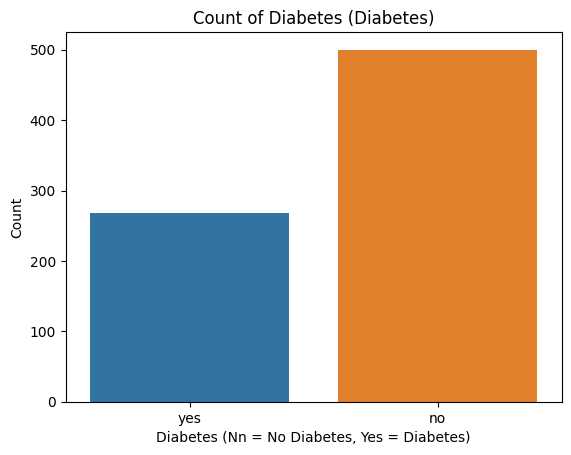

In [ ]:
# Create a countplot for the target variable 'cardio'
sns.countplot(x='Outcome', data=health_data)

# Set title and labels
plt.title('Count of Diabetes (Diabetes)')
plt.xlabel('Diabetes (Nn = No Diabetes, Yes = Diabetes)')
plt.ylabel('Count')

# Show plot
plt.show()

<b>We observe that data distribution for samples with heart disease and without heart disease is even.

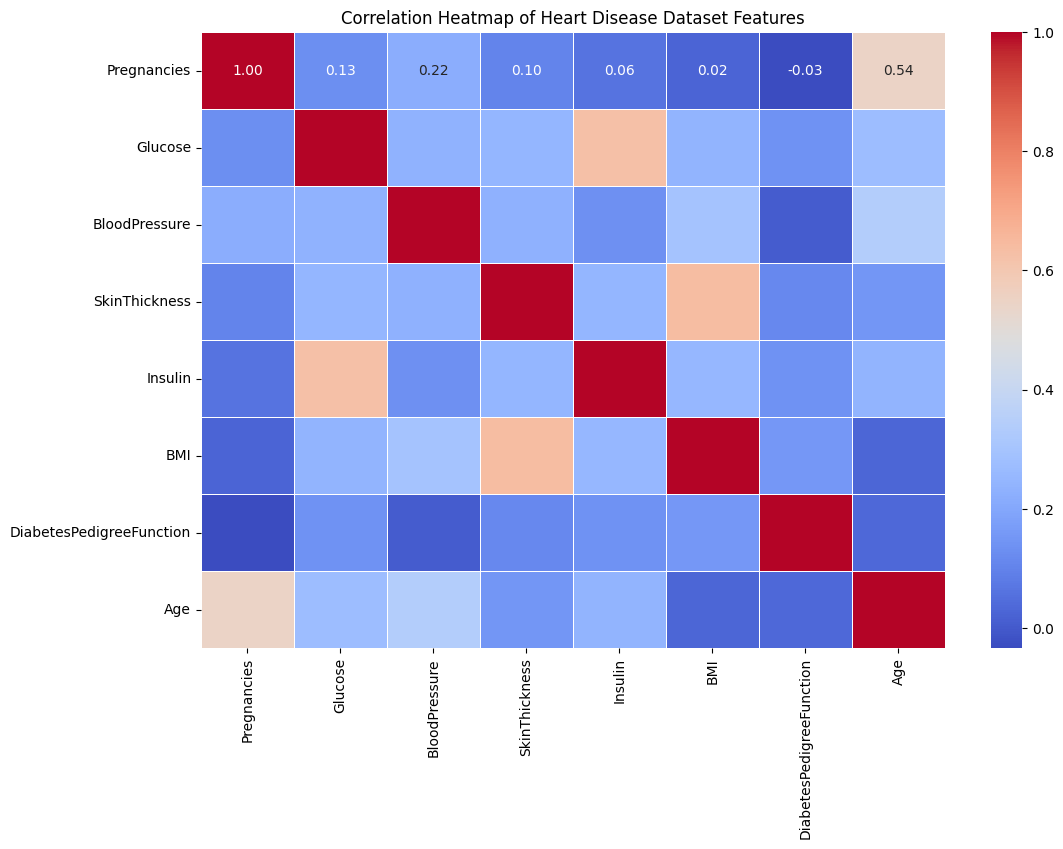

In [ ]:
# Compute the correlation matrix
df = health_data.drop(columns=['Outcome'], errors='ignore')
corr_matrix = df.corr()

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(12, 8))  # Set the figure size for better readability
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

# Set the title
plt.title('Correlation Heatmap of Heart Disease Dataset Features')

# Show the plot
plt.show()


Drop features that have a high correlation (above a certain threshold), you can follow these steps:

1. Compute the correlation matrix.
2. Identify pairs of features that have a correlation coefficient greater than a specified threshold (e.g., 0.9).
3. Drop one of the highly correlated features from each pair to avoid redundancy.

In [ ]:
# Compute the correlation matrix
corr_matrix = df.corr().abs()  # Use absolute values to consider both positive and negative correlations

# Select the upper triangle of the correlation matrix
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.9 (or your preferred threshold)
threshold = 0.9
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > threshold)]

# Drop highly correlated features
df_reduced = df.drop(columns=to_drop)


# Print the remaining features
print("Remaining features after dropping highly correlated ones:", df_reduced.columns)


Remaining features after dropping highly correlated ones: Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age'],
      dtype='object')


# Diabetes Distribution For Different Featues

In [ ]:
# Generic function to plot feature ranges versus proportion of positive outcome ('yes')
def plot_feature_ranges_vs_outcome(df, features, outcome_col, bins=15):
    # Ensure only rows with valid 'yes' and 'no' in the outcome column are mapped
    df = df[df[outcome_col].isin(['yes', 'no'])].copy()

    # Map 'yes' to 1 and 'no' to 0 in the outcome column
    df[outcome_col] = df[outcome_col].map({'yes': 1, 'no': 0})

    # Drop rows where any feature or outcome is missing
    df = df.dropna(subset=features + [outcome_col])

    for feature in features:
        # Create dynamic bins for each feature using pandas.cut
        df[f'{feature}_range'] = pd.cut(df[feature], bins=bins)

        # Group by the feature range and calculate the proportion of 'yes'
        feature_vs_outcome = df.groupby(f'{feature}_range')[outcome_col].mean().reset_index()

        # Plot the feature range versus the proportion of 'yes' outcome
        plt.figure(figsize=(10, 6))
        sns.barplot(x=f'{feature}_range', y=outcome_col, data=feature_vs_outcome)
        plt.title(f'Proportion of "yes" Outcome vs {feature} Ranges')
        plt.xlabel(f'{feature} ranges')
        plt.ylabel('Proportion of "yes" Outcome')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()


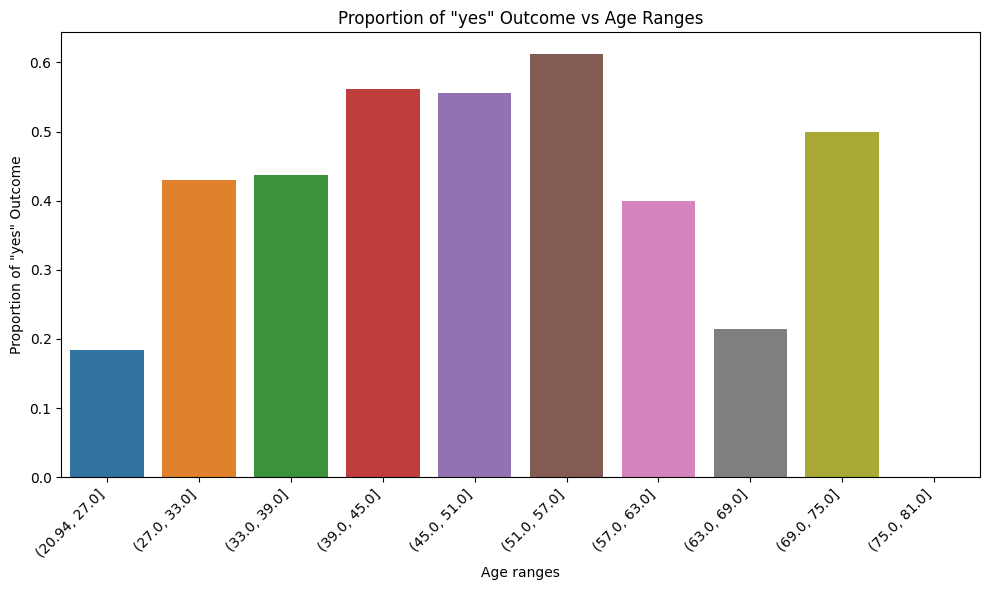

In [ ]:
#features = ['Age', 'Glucose', 'BloodPressure', 'Insulin', 'BMI']
features = ['Age']
plot_feature_ranges_vs_outcome(health_data, features, outcome_col='Outcome', bins=10)


<b>We observe that young are less risk of diabetes. Maximum risk is between 39 and 60

# Diabetes with different number of pregencies

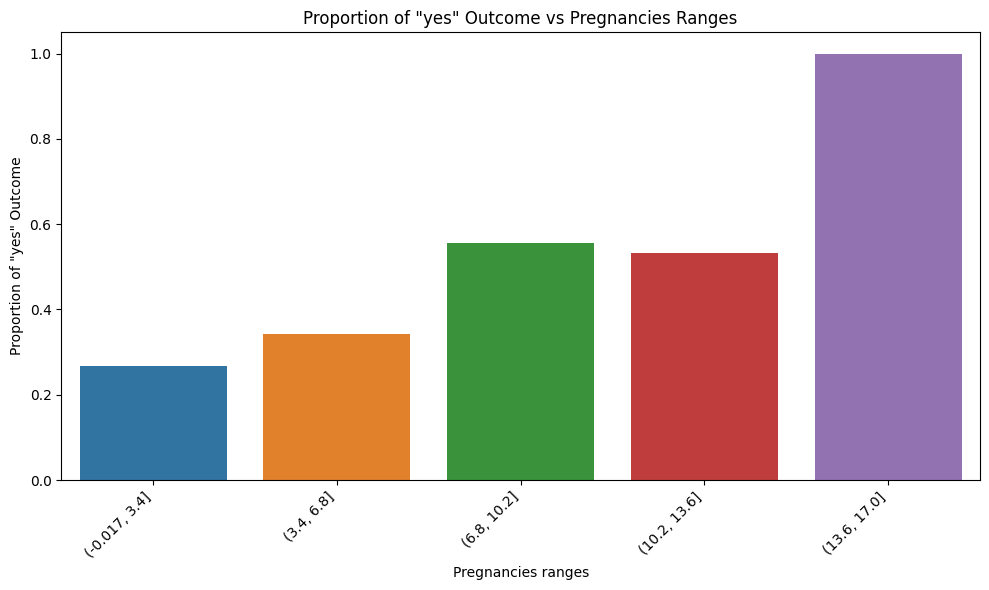

In [ ]:
#features = ['Age', 'Glucose', 'BloodPressure', 'Insulin', 'BMI']
features = ['Pregnancies']
plot_feature_ranges_vs_outcome(health_data, features, outcome_col='Outcome', bins=5)


<b>Observation</b>
We observe that higher number of pregencies carries diabetes risk

# Diabetes with BMI

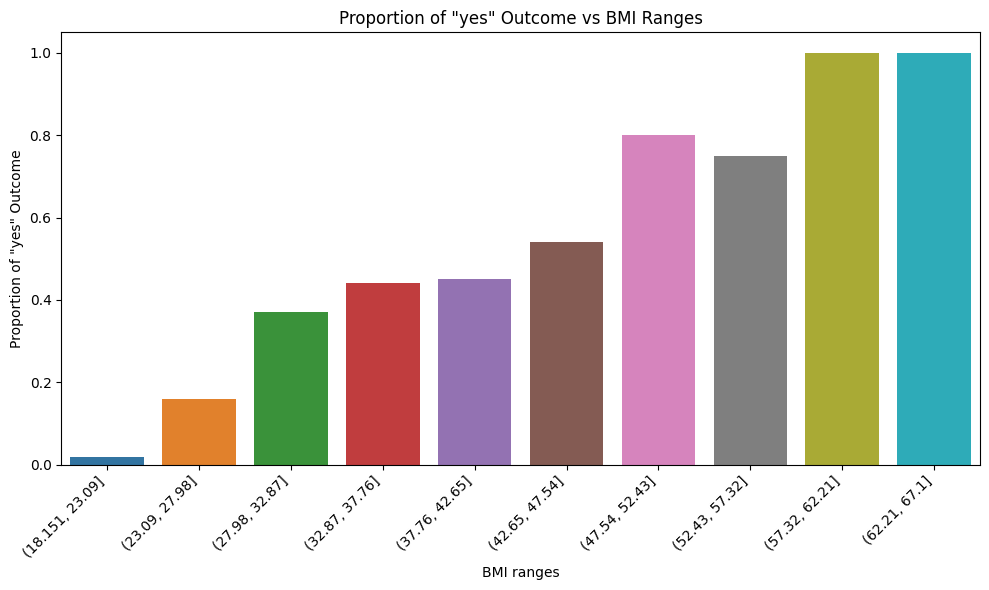

In [ ]:
#features = ['Age', 'Glucose', 'BloodPressure', 'Insulin', 'BMI']
features = ['BMI']
plot_feature_ranges_vs_outcome(health_data, features, outcome_col='Outcome', bins=10)


<b> Observations:<br>
Higher BMI contributes to diabetes

# Diabetes with Blood Pressure

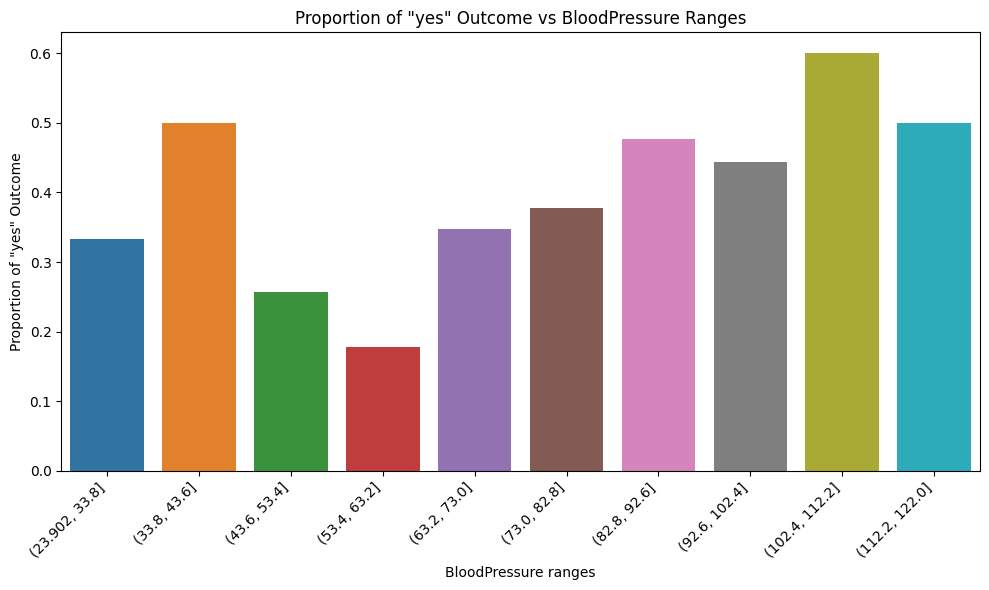

In [ ]:
#features = ['Age', 'Glucose', 'BloodPressure', 'Insulin', 'BMI']
features = ['BloodPressure']
plot_feature_ranges_vs_outcome(health_data, features, outcome_col='Outcome', bins=10)


<b> Diabetes is spread across BP ranges

# Diabetes with Insulin

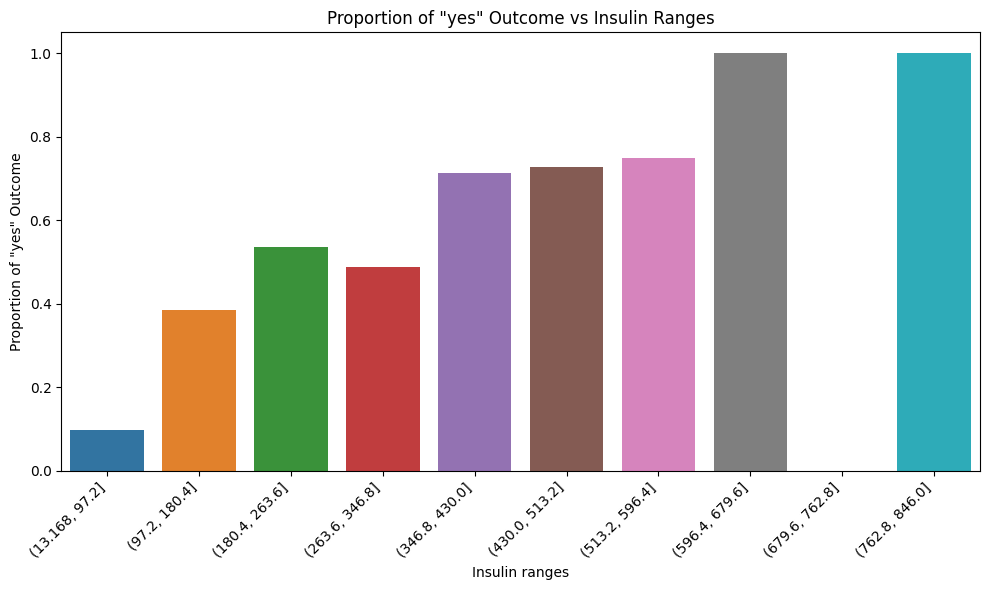

In [ ]:
#features = ['Age', 'Glucose', 'BloodPressure', 'Insulin', 'BMI']  # Specify the features to plot
features = ['Insulin']
plot_feature_ranges_vs_outcome(health_data, features, outcome_col='Outcome', bins=10)


<b>High insulin contributes to diabetes

# Feature Engineering (1/2)

<b>Following types of feature will be modified :
1. Label Encoding <br>

In [ ]:
health_data['Outcome'] = health_data['Outcome'].map({'yes': 1, 'no': 0})

health_data.head() # To verify the changes

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6.0,148.0,72.0,35.0,169.0,33.6,0.627,50.0,1
1,1.0,85.0,66.0,29.0,58.6,26.6,0.351,31.0,0
2,8.0,183.0,64.0,25.8,164.6,23.3,0.672,32.0,1
3,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21.0,0
4,0.0,137.0,40.0,35.0,168.0,43.1,2.288,33.0,1


# Creating Train, Validation and Test

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

# Split data into train and test sets (stratified)
train, test = train_test_split(
    health_data,
    test_size=0.15,
    random_state=1,
    stratify=health_data['Outcome']
)

# Reset index for both train and test sets
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

# Further split train into train and validation sets (stratified)
train, validation = train_test_split(
    train,
    test_size=0.10,
    random_state=1,
    stratify=train['Outcome']
)

# Reset index for the validation set
validation.reset_index(drop=True, inplace=True)

# Print the shapes and default rates for each dataset
print(f"Shape for Train: {train.shape}, Default Rate: {train['Outcome'].mean():.2f}")
print(f"Shape for Validation: {validation.shape}, Default Rate: {validation['Outcome'].mean():.2f}")
print(f"Shape for Test: {test.shape}, Default Rate: {test['Outcome'].mean():.2f}")


Shape for Train: (586, 9), Default Rate: 0.35
Shape for Validation: (66, 9), Default Rate: 0.35
Shape for Test: (116, 9), Default Rate: 0.34


# Feature Selection

## Correlation Analysis

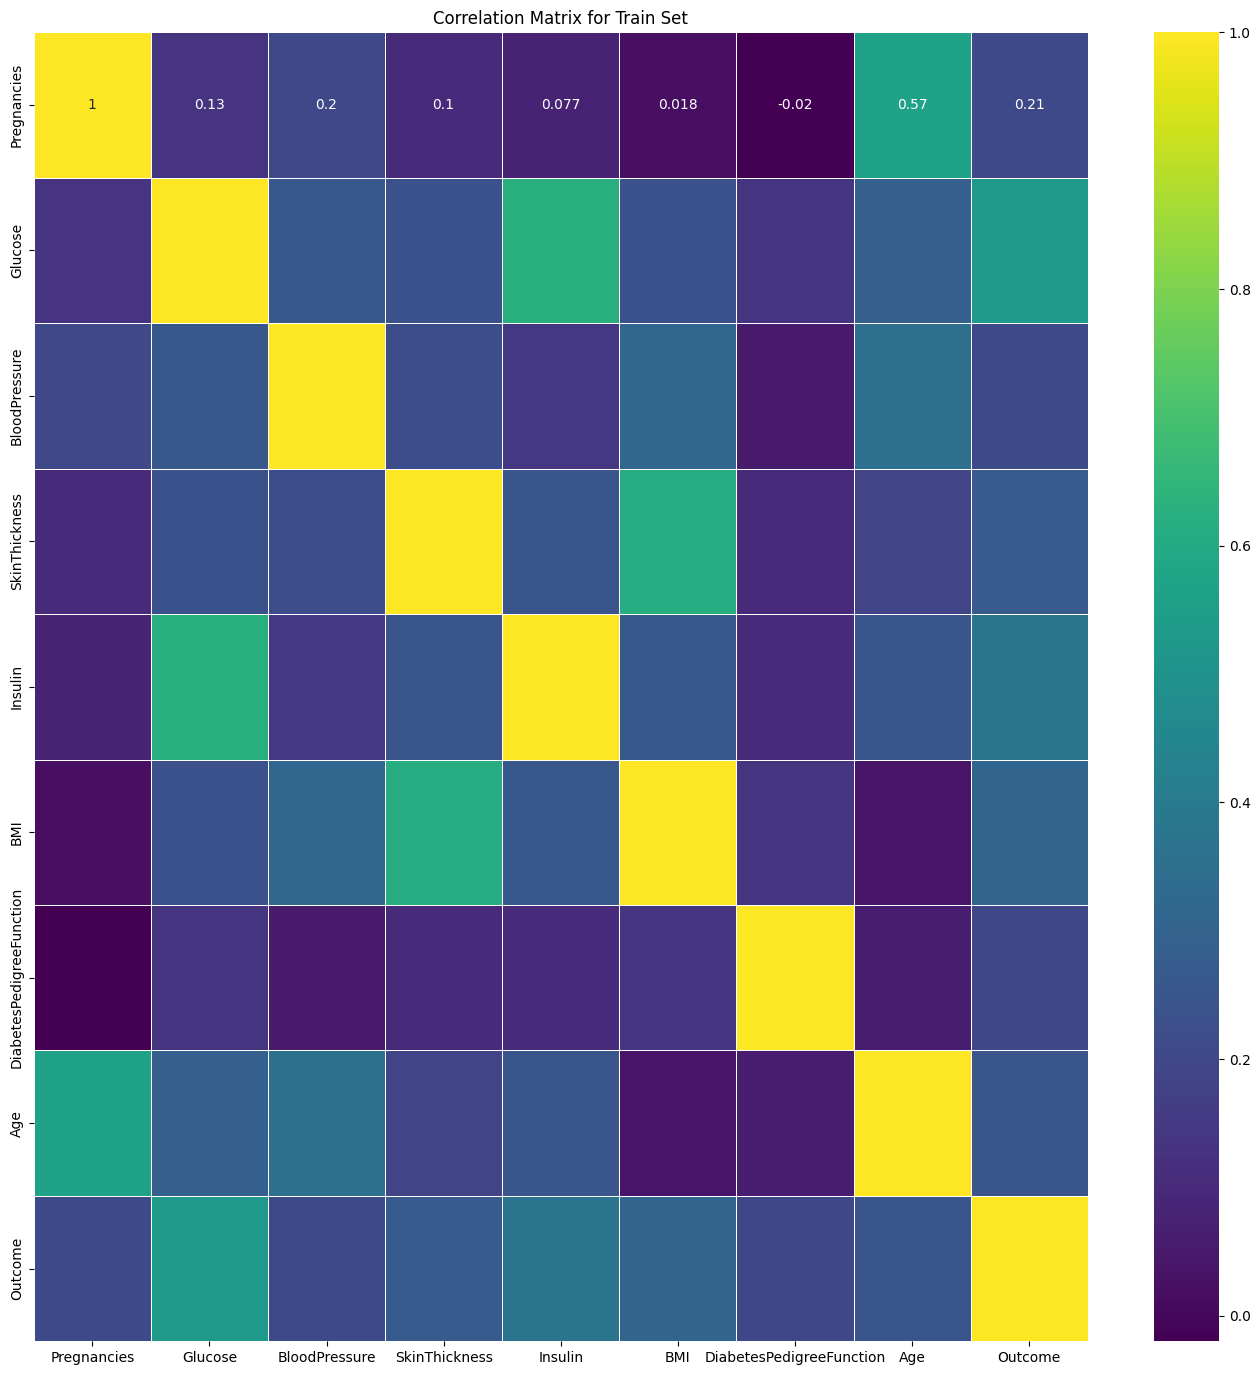

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix for numeric features only
correlation_matrix = train.corr()

# Plot the heatmap
plt.figure(figsize=(17, 17))
sns.heatmap(correlation_matrix, annot=True, cmap='viridis', linewidths=0.5)
plt.title("Correlation Matrix for Train Set")
plt.show()


# Backward Feature Selection

In [ ]:
columns_set = train.columns.tolist()
columns_set

['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age',
 'Outcome']

In [ ]:
clf = DecisionTreeClassifier(random_state=1)
recursive_eliminator = RFECV(clf,cv=StratifiedKFold(3),min_features_to_select=10,step=2,scoring="f1")
recursive_eliminator.fit(train[columns_set], train['Outcome'])

RFECV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
      estimator=DecisionTreeClassifier(random_state=1),
      min_features_to_select=10, scoring='f1', step=2)

In [ ]:
columns_retained = train[columns_set].columns[recursive_eliminator.get_support()].values

In [ ]:
columns_retained

array(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness',
       'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype=object)

In [ ]:
len(columns_retained)

9

# Modelling

In [ ]:
def evaluate_metrics(y_true,y_pred,model_name):

    classification_metrics={}
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    classification_metrics['model_name']=model_name
    classification_metrics["roc_auc"]=(roc_auc_score(y_true, y_pred))
    classification_metrics['au_prc'] = average_precision_score(y_true, y_pred)
    classification_metrics['brier_score']=brier_score_loss(y_true, y_pred)

    ### optimal Threshold#########
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]

    y_pred=np.where(y_pred>optimal_threshold,1,0)

    classification_metrics['recall_score']=recall_score(y_true,y_pred)
    classification_metrics['precision_score']=precision_score(y_true, y_pred)
    classification_metrics['f1_score']=f1_score(y_true, y_pred)
    classification_metrics['optimal_threshold']=optimal_threshold if optimal_threshold != np.inf else 1



    return pd.DataFrame([classification_metrics],columns=classification_metrics.keys())

## Base Model : Predicting Majority Class

In [ ]:
target="Outcome"
base_model_metrics_validation=evaluate_metrics(validation[target].tolist(),[1]*len(validation),"base_model_validation")
base_model_metrics_test=evaluate_metrics(test[target].tolist(),[1]*len(test),"base_model_test")
base_model_metrics_train=evaluate_metrics(train[target].tolist(),[1]*len(train),"base_model_train")

In [ ]:
base_model_results=pd.concat([base_model_metrics_train,base_model_metrics_validation,base_model_metrics_test], ignore_index=True)
base_model_results.columns

Index(['model_name', 'roc_auc', 'au_prc', 'brier_score', 'recall_score',
       'precision_score', 'f1_score', 'optimal_threshold'],
      dtype='object')

<Figure size 1600x1000 with 0 Axes>

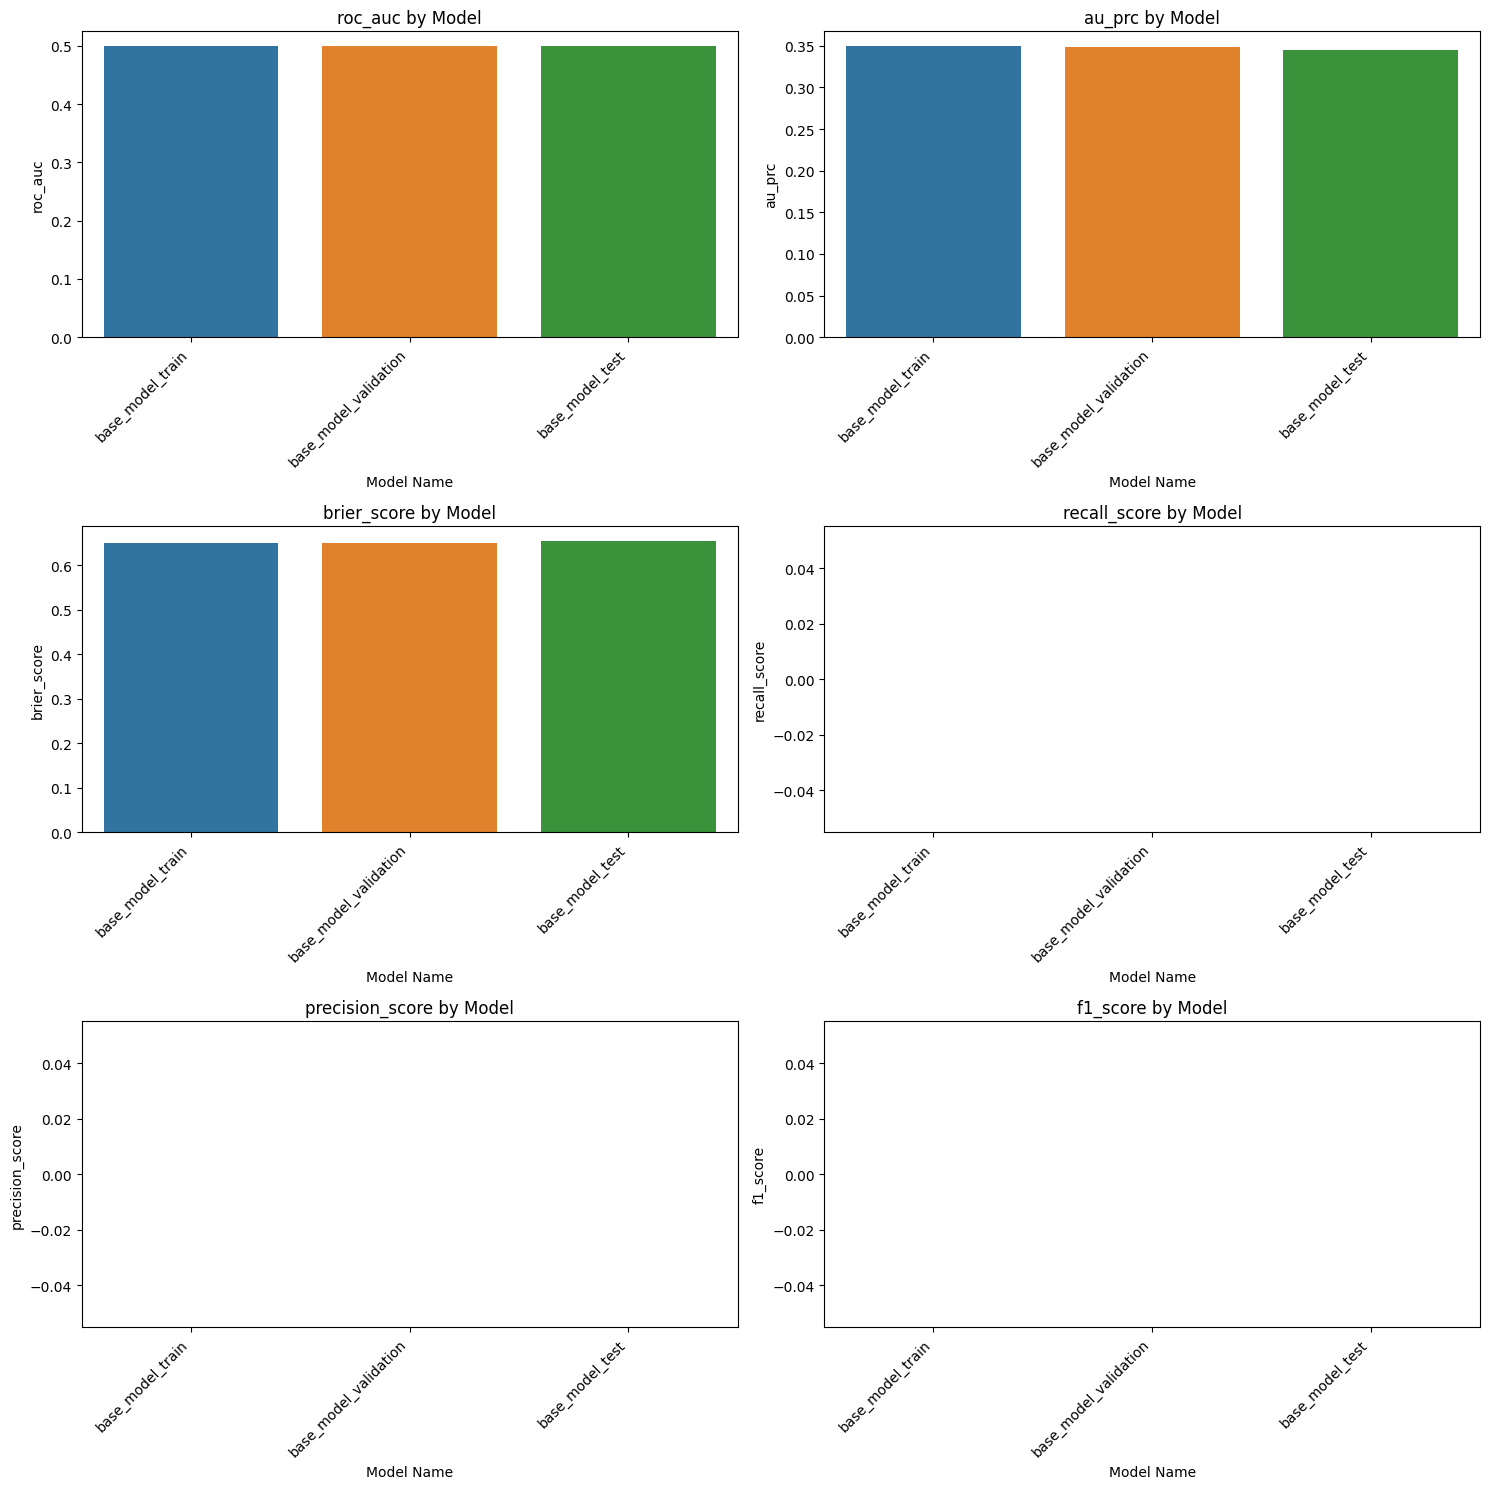

In [ ]:
# Set the figure size
plt.figure(figsize=(16, 10))

# Define the metrics you want to plot
metrics = ['roc_auc', 'au_prc', 'brier_score', 'recall_score', 'precision_score', 'f1_score']

# Create a grid of subplots for each metric
fig, axes = plt.subplots(3, 2, figsize=(15, 15))  # 3 rows, 2 columns of plots
axes = axes.flatten()  # Flatten the axes array for easier indexing

# Plot each metric
for i, metric in enumerate(metrics):
    sns.barplot(x='model_name', y=metric, data=base_model_results, ax=axes[i])
    axes[i].set_title(f'{metric} by Model')
    axes[i].set_xlabel('Model Name')
    axes[i].set_ylabel(metric)
    axes[i].set_xticklabels(base_model_results['model_name'].unique(), rotation=45, ha='right')

# Adjust layout
plt.tight_layout()
plt.show()

**ML Flow for the Base Model**

In [ ]:
with mlflow.start_run():
          # Log the hyperparameters
          mlflow.log_param("optimal threshold",base_model_metrics_test['optimal_threshold'][0])
          #mlflow.log_param("n estimators",n_estimators)
          #mlflow.log_param("gamma",gamma)



          # Log the loss metric
          mlflow.log_metric("Recall Score", base_model_metrics_test['recall_score'][0])
          mlflow.log_metric("Precision Score", base_model_metrics_test['precision_score'][0])
          mlflow.log_metric("F1 Score", base_model_metrics_test['f1_score'][0])
          mlflow.log_metric("Au_Prc", base_model_metrics_test['au_prc'][0])
          mlflow.log_metric("Brier_Score", base_model_metrics_test['brier_score'][0])
          #mlflow.log_metric("recall_score", recall_score(y_true,y_pred))


          # Set a tag that we can use to remind ourselves what this run was for
          mlflow.set_tag("Predicting Majority Class", "Base Model")

          # Infer the model signature
          #signature = infer_signature(train[universal_feature_set].astype(float), xgboost_tuna.predict(train[universal_feature_set].astype(float)))

          # Log the model
          model_info = mlflow.sklearn.log_model(
          sk_model='base model test',
          artifact_path="mlrun_diabetes01",
          #signature=signature,
          #input_example=train[universal_feature_set].astype(float),
          registered_model_name="Predicting Diabetes Model 005",
                      )

2024/09/23 09:24:36 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2024/09/23 09:24:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'Predicting Diabetes Model 005'.
2024/09/23 09:24:42 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Predicting Diabetes Model 005, version 1
Created version '1' of model 'Predicting Diabetes Model 005'.
2024/09/23 09:24:42 INFO mlflow.tracking._tracking_service.client: 🏃 View run persistent-trout-364 at: http://localhost:5000/#/experiments/4/runs/3781cade9c3b459881a2dadc95ff72c0.
2024/09/23 09:24:42 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/4.


# AutoML Methods - H2O AutoML

**H2O AutoML** is an advanced AutoML framework designed to automate the process of building and optimizing machine learning models. By conducting a comprehensive search across multiple algorithms (such as Gradient Boosting Machines, Random Forests, XGBoost, and more), H2O AutoML automatically selects the best model based on performance metrics such as AUC, RMSE, or log loss. It simplifies the model development process by performing hyperparameter tuning, ensembling, and model stacking, allowing users to obtain high-performing models with minimal manual intervention.

1. H2O AutoML supports both classification and regression tasks and integrates with popular languages like Python and R. One of the key features of H2O AutoML is its leaderboard, which ranks the models according to their performance, allowing users to choose the best model for their specific use case. Additionally, H2O provides flexibility for exporting models in various formats (such as MOJO and binary models) for easy deployment in production.

2. H2O AutoML is highly scalable, making it suitable for handling large datasets and complex models. Its ease of use and powerful optimization capabilities make it a valuable tool for both data scientists and business users who want to streamline their machine learning workflows without sacrificing model performance.

3. Supports Multiple Algorithms: Automatically trains and tunes a variety of models including GBM, XGBoost, Random Forest, GLM, and Deep Learning.
Automatic Model Ensembling: Combines the best-performing models to create a more robust, stacked ensemble for improved performance.
4. Scalability: Suitable for large datasets and distributed environments, making it ideal for big data applications.
Model Interpretability: Can be paired with XAI tools like SHAP and LIME to provide transparent insights into the model's decision-making process.
Exportability: Models can be exported in MOJO or binary formats for fast, production-ready scoring without requiring a full H2O cluster.


In [ ]:
pip install h2o

  Using cached h2o-3.46.0.5-py2.py3-none-any.whl
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the dataset
df = pd.read_csv('diabetes_dataset.csv')

# Assuming 'Outcome' is the target column
X = df.drop('Outcome', axis=1)
y = df['Outcome']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
import h2o
from h2o.automl import H2OAutoML
h2o.init()

# Convert pandas dataframe to H2O Frame
train = h2o.H2OFrame(pd.concat([X_train, y_train], axis=1))
test = h2o.H2OFrame(pd.concat([X_test, y_test], axis=1))

# Define target and features
target = 'Outcome'
features = X_train.columns.tolist()

# Run AutoML
aml = H2OAutoML(max_models=20, seed=42, verbosity='info')
aml.train(x=features, y=target, training_frame=train)

# View the AutoML Leaderboard
lb = aml.leaderboard
print(lb)

# Evaluate on the test set
preds = aml.leader.predict(test)
print(preds.head())


Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.24" 2024-07-16; OpenJDK Runtime Environment (build 11.0.24+8-post-Ubuntu-1ubuntu322.04); OpenJDK 64-Bit Server VM (build 11.0.24+8-post-Ubuntu-1ubuntu322.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.10/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp8mm2lcwd
  JVM stdout: /tmp/tmp8mm2lcwd/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp8mm2lcwd/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.5
H2O_cluster_version_age:,25 days
H2O_cluster_name:,H2O_from_python_unknownUser_2snnvu
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.170 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |
15:40:23.848: Project: AutoML_1_20240923_154023
15:40:23.851: 5-fold cross-validation will be used.
15:40:23.851: Setting stopping tolerance adaptively based on the training frame: 0.04035671561356309
15:40:23.851: Build control seed: 42
15:40:23.852: training frame: Frame key: AutoML_1_20240923_154023_training_Key_Frame__upload_af91ab3ba3ac8a8640b9e74606f24acc.hex    cols: 9    rows: 614  chunks: 1    size: 11781  checksum: 1465734456644361918
15:40:23.853: validation frame: NULL
15:40:23.853: leaderboard frame: NULL
15:40:23.853: blending frame: NULL
15:40:23.853: response column: Outcome
15:40:23.853: fold column: null
15:40:23.853: weights column: null
15:40:23.890: Loading execution steps: [{XGBoost : [def_2 (1g, 10w), def_1 (2g, 10w), def_3 (3g, 10w), grid_1 (4g, 90w), lr_se

# Summarizing the Modelling Results

In [ ]:
leaderboard_df = lb.as_data_frame()

# Display the first few rows of the DataFrame
leaderboard_df.head(50)

/usr/local/lib/python3.10/dist-packages/h2o/frame.py:1981: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


,model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
0,GBM_1_AutoML_1_20240923_154023,0.839743,0.468472,0.697023,0.217192,0.393521,0.154859
1,StackedEnsemble_BestOfFamily_1_AutoML_1_202409...,0.839667,0.467743,0.691798,0.222542,0.394057,0.155281
2,StackedEnsemble_AllModels_1_AutoML_1_20240923_...,0.838795,0.468861,0.684696,0.216384,0.393970,0.155213
3,GBM_grid_1_AutoML_1_20240923_154023_model_2,0.837074,0.473720,0.674865,0.214844,0.393094,0.154523
4,GLM_1_AutoML_1_20240923_154023,0.836758,0.479264,0.685950,0.232301,0.398187,0.158553
5,GBM_4_AutoML_1_20240923_154023,0.835066,0.474311,0.692845,0.222987,0.394511,0.155639
6,GBM_3_AutoML_1_20240923_154023,0.831577,0.477570,0.690909,0.226722,0.398831,0.159066
7,GBM_2_AutoML_1_20240923_154023,0.830711,0.479558,0.684720,0.239560,0.398179,0.158546
8,XGBoost_1_AutoML_1_20240923_154023,0.828422,0.484591,0.689507,0.235532,0.401384,0.161109
9,XGBoost_3_AutoML_1_20240923_154023,0.825776,0.524605,0.656659,0.225329,0.409396,0.167605


/usr/local/lib/python3.10/dist-packages/h2o/frame.py:1981: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


<Figure size 1200x800 with 0 Axes>

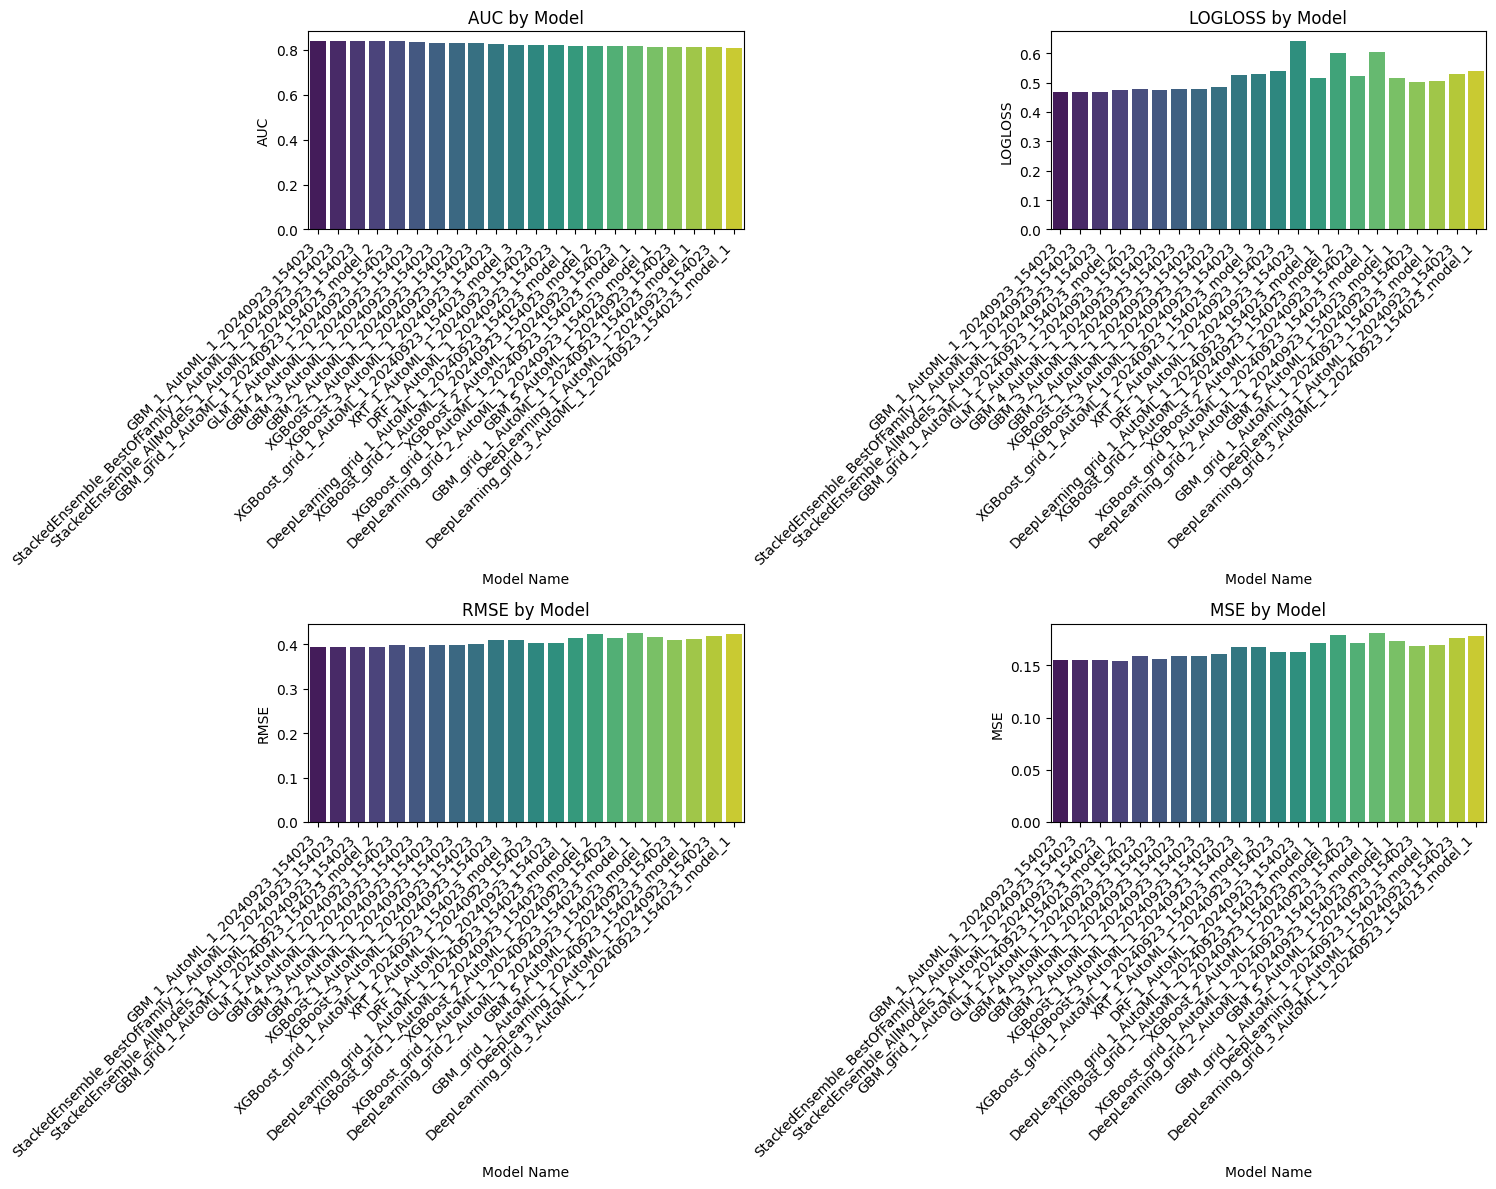

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select relevant columns for plotting
metrics = ['auc', 'logloss', 'rmse', 'mse']
leaderboard_df = lb.as_data_frame()

model_names = leaderboard_df['model_id']

# Set the figure size
plt.figure(figsize=(12, 8))

# Create a grid of subplots for each metric
fig, axes = plt.subplots(2, 2, figsize=(15, 12))  # 2 rows, 2 columns
axes = axes.flatten()  # Flatten the axes array for easier indexing

# Plot each metric using Seaborn
for i, metric in enumerate(metrics):
    sns.barplot(x=model_names, y=leaderboard_df[metric], ax=axes[i], palette='viridis')
    axes[i].set_title(f'{metric.upper()} by Model')
    axes[i].set_xlabel('Model Name')
    axes[i].set_ylabel(metric.upper())
    axes[i].set_xticklabels(model_names, rotation=45, ha='right')

# Adjust layout
plt.tight_layout()
plt.show()

In [ ]:
# Get all model IDs from the leaderboard
model_ids = list(lb['model_id'].as_data_frame().iloc[:, 0])

# Dictionary to store model paths
model_paths = {}

# Save each model to binary format and store the path
for model_id in model_ids:
    model = h2o.get_model(model_id)
    model_path = h2o.save_model(model=model, path="/content/h2o_models", force=True)
    model_paths[model_id] = model_path

# Save the model paths in a .pkl file
with open("h2o_model_paths.pkl", "wb") as f:
    pickle.dump(model_paths, f)

print("All models have been saved and the paths are stored in 'h2o_model_paths.pkl'.")


/usr/local/lib/python3.10/dist-packages/h2o/frame.py:1981: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


All models have been saved and the paths are stored in 'h2o_model_paths.pkl'.


In [ ]:
best_model = aml.leader
best_model

Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_1_AutoML_1_20240923_154023


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    43                 43                          4526                   2            4            2.67442       3             5             3.74419

ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.13355275314244322
RMSE: 0.3654487011092572
LogLoss: 0.4132737870161906
Mean Per-Class Error: 0.19254094809923547
AUC: 0.8838350134054536
AUCPR: 0.7674093174210207
Gini: 0.7676700268109071

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3065037582552617
       no    yes    Error    Rate
-----  ----  -----  -------  -------------
no     288   113    0.2818   (113.0/401.0)
yes    22    191    0.1033   (22.0/213.0)
Total  310   304    0.2199   (135.0/614.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.306504     0.738878  223
max f2                       0.204612     0.849917  263
max f0point5                 0.541638     0.739082  121
max accuracy                 0.516759     0.809446  137
max precision                0.874412     1         0
max recall                   0.0306949    1         388
max specificity              0.874412     1         0
max absolute_mcc             0.443397     0.586021  163
max min_per_class_accuracy   0.39467      0.793017  182
max mean_per_class_accuracy  0.306504     0.807459  223
max tns                      0.874412     401       0
max fns                      0.874412     212       0
max fps                      0.0199846    401       399
max tps                      0.0306949    213       388
max tnr                      0.874412     1         0
max fnr                      0.874412     0.995305  0
max fpr                      0.0199846    1         399
max tpr                      0.0306949    1         388

Gains/Lift Table: Avg response rate: 34.69 %, avg score: 34.66 %
group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0114007                   0.848985           2.47082    2.47082            0.857143         0.857943   0.857143                    0.857943            0.028169        0.028169                   147.082   147.082            0.0256752
2        0.0211726                   0.835907           2.40219    2.43915            0.833333         0.842526   0.846154                    0.850827            0.0234742       0.0516432                  140.219   143.915            0.0466557
3        0.0309446                   0.828093           2.40219    2.42748            0.833333         0.830909   0.842105                    0.844537            0.0234742       0.0751174                  140.219   142.748            0.0676361
4        0.0407166                   0.822069           2.40219    2.42141            0.833333         0.825056   0.84                        0.839862            0.0234742       0.0985915                  140.219   142.141            0.0886165
5        0.0521173                   0.818099           2.05902    2.34214            0.714286         0.819036   0.8125                   

# Model Interpretations Using Variable Importance Plots

**Variable Importance Plots** offer a visual interpretation of machine learning models by ranking features based on their contribution to the model's predictions. These plots help to highlight which features are most influential, aiding in understanding how the model makes its decisions.

The **Bar Plot of Feature Importance** provides a global view of the relative importance of features used in the model. Features are sorted by their percentage contribution, enabling users to quickly identify the most impactful features. Each bar represents a feature, with its length corresponding to its importance.

By focusing on the percentage contribution of each feature, this plot enables an intuitive understanding of the model's decision-making process, illustrating how much each feature affects the predictions. This is particularly useful for assessing the global impact of features on the model's overall performance.

The **Importance Percentage** on the x-axis shows the relative contribution of each feature, while the Features on the y-axis list the variables used in the model. This plot is an essential tool for model validation, feature selection, and further analysis of how features influence the model's outcomes.



In [ ]:
# Get variable importance from the best model (works for tree-based models like GBM, XGBoost)
variable_importance = best_model.varimp(use_pandas=True)

# Print the feature importances
print(variable_importance)


                   variable  relative_importance  scaled_importance  \
0                   Glucose           136.458649           1.000000   
1                       Age            44.601028           0.326846   
2                   Insulin            42.162167           0.308974   
3                       BMI            37.809692           0.277078   
4             SkinThickness            20.162033           0.147752   
5  DiabetesPedigreeFunction            13.784797           0.101018   
6             BloodPressure             1.623452           0.011897   
7               Pregnancies             0.851550           0.006240   

   percentage  
0    0.458756  
1    0.149943  
2    0.141744  
3    0.127111  
4    0.067782  
5    0.046343  
6    0.005458  
7    0.002863  


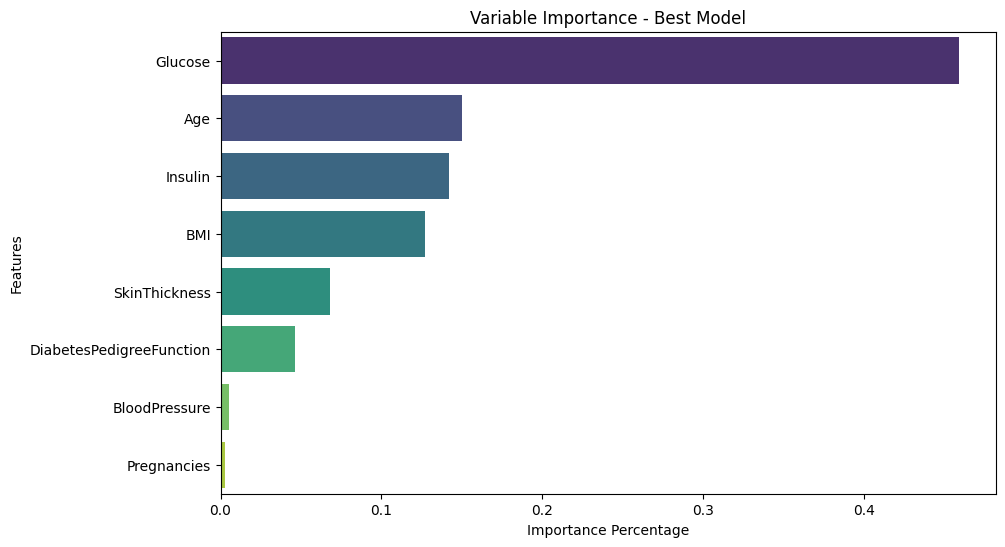

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Sort the variable importance by importance value for better visualization
variable_importance_sorted = variable_importance.sort_values(by="percentage", ascending=False)

# Plot the variable importance
plt.figure(figsize=(10, 6))
sns.barplot(x='percentage', y='variable', data=variable_importance_sorted, palette="viridis")
plt.title('Variable Importance - Best Model')
plt.xlabel('Importance Percentage')
plt.ylabel('Features')
plt.show()


Variable Importance (for tree-based models like GBM, XGBoost)
H2O provides variable importance plots to show which features have the most influence on the model's predictions.
You can access variable importance using the .varimp() function, which ranks the features based on their contribution to the model's decision-making process.

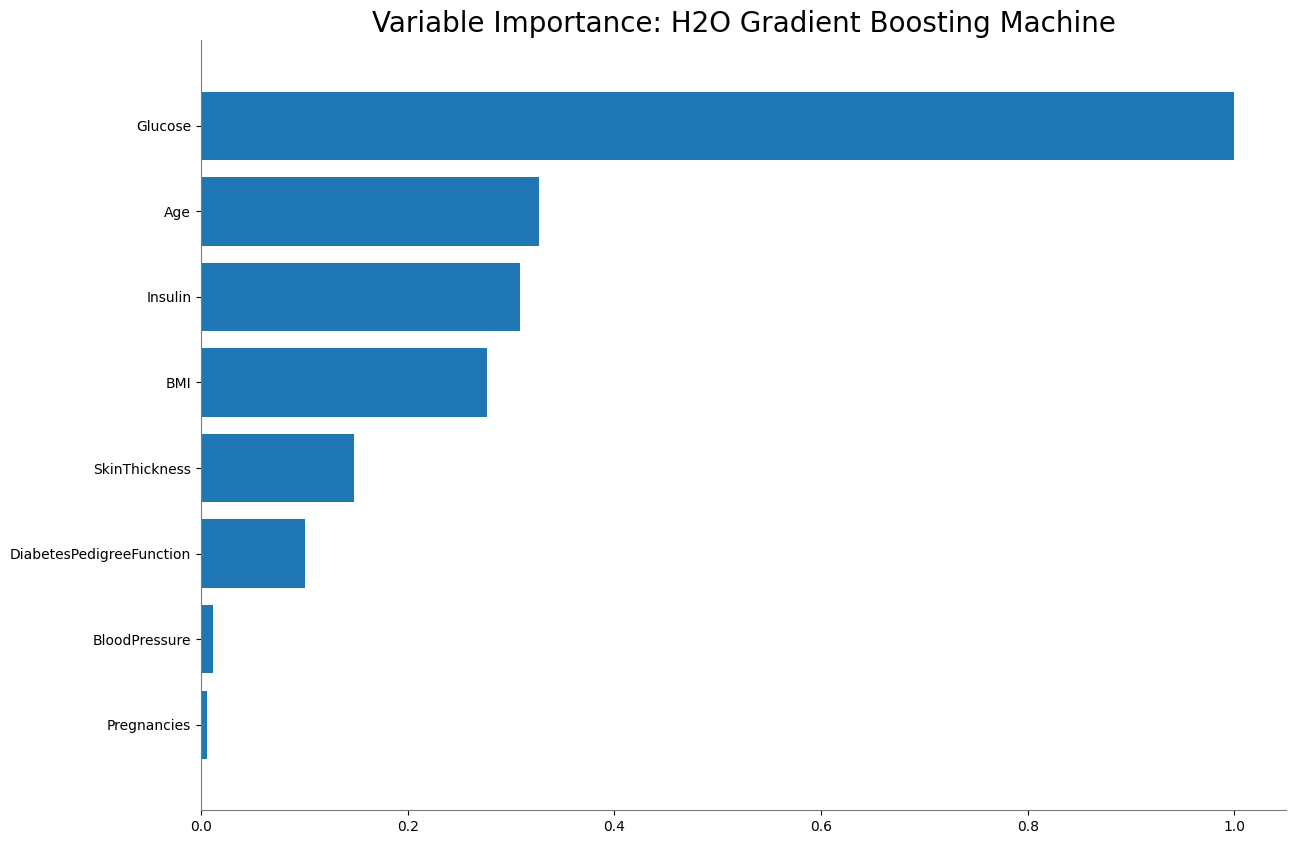

<Figure size 640x480 with 0 Axes>

In [ ]:
best_model.varimp_plot()

1. Variable Importance (Global Explanation)
Description: For tree-based models (like GBM, Random Forest, and XGBoost), this shows which features are most important in driving the model's decisions across the entire dataset.
Output: A bar plot that ranks features based on their importance (percentage contribution to predictions).

2. Partial Dependence Plot (PDP)
Description: This shows the marginal effect of a single feature on the predicted outcome, holding all other features constant. It helps explain how changes in a specific feature impact predictions globally.
Output: A plot showing the relationship between feature values and predicted outcome.

3. Individual Conditional Expectation (ICE)
Description: ICE plots are similar to partial dependence plots but for individual observations. It shows how each observation reacts to changes in a feature, allowing you to see individual behavior instead of an aggregated effect.
Output: A series of line plots showing how each instance reacts to changes in a particular feature.
4. SHAP Summary Plot
Description: Shapley values (or SHAP) provide an explanation of feature contributions for a specific prediction. The SHAP summary plot shows feature importance, but with more detailed local explanations of how each feature contributes to the prediction for each instance.
Output: A SHAP summary plot that displays the distribution of SHAP values for each feature across all instances.
5. SHAP Individual Plot
Description: This explains individual predictions using Shapley values, showing how much each feature contributes to the prediction of a specific instance. You can see how the model arrived at a particular prediction for an instance.
Output: A waterfall-like plot showing the contribution of each feature to an individual prediction.
6. Model Performance
Description: Displays standard performance metrics such as:
Confusion Matrix (for classification tasks): Shows the counts of correct and incorrect classifications for different classes.
ROC Curve: Displays the trade-off between true positive rate and false positive rate.
Gains/Lift Charts: Useful for classification problems to see how well the model ranks predicted probabilities.
Example Outputs:

Confusion Matrix for classification tasks.
ROC Curve for classification tasks.
7. Residual Analysis
Description: This shows how well the model is predicting, by visualizing the residuals (differences between predicted and actual values). It's useful for identifying whether the model is systematically under- or over-predicting.
Output: Plots showing the residuals or prediction errors.
8. Learning Curve
Description: For algorithms that support staged training (like GBM or XGBoost), this plot shows how the model's performance evolves as more training iterations are performed. It can help identify overfitting or underfitting.
Output: A line plot showing the evolution of the model’s performance over time.


# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## GBM_1_AutoML_1_20240923_154023

,no,yes,Error,Rate
no,69.0,30.0,0.303,(30.0/99.0)
yes,11.0,44.0,0.2,(11.0/55.0)
Total,80.0,74.0,0.2662,(41.0/154.0)


# Learning Curve Plot

> Learning curve plot shows the loss function/metric dependent on number of iterations or trees for tree-based algorithms. This plot can be useful for determining whether the model overfits.

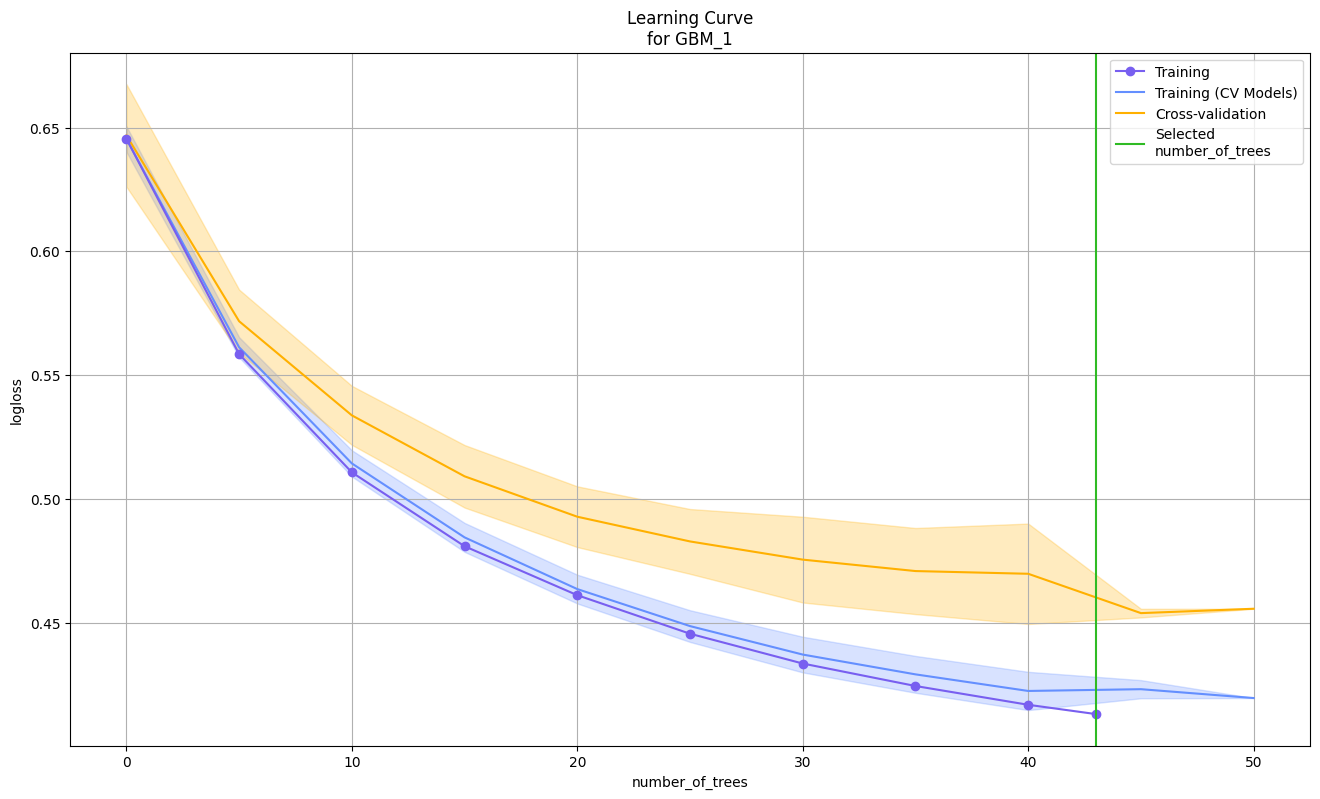

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

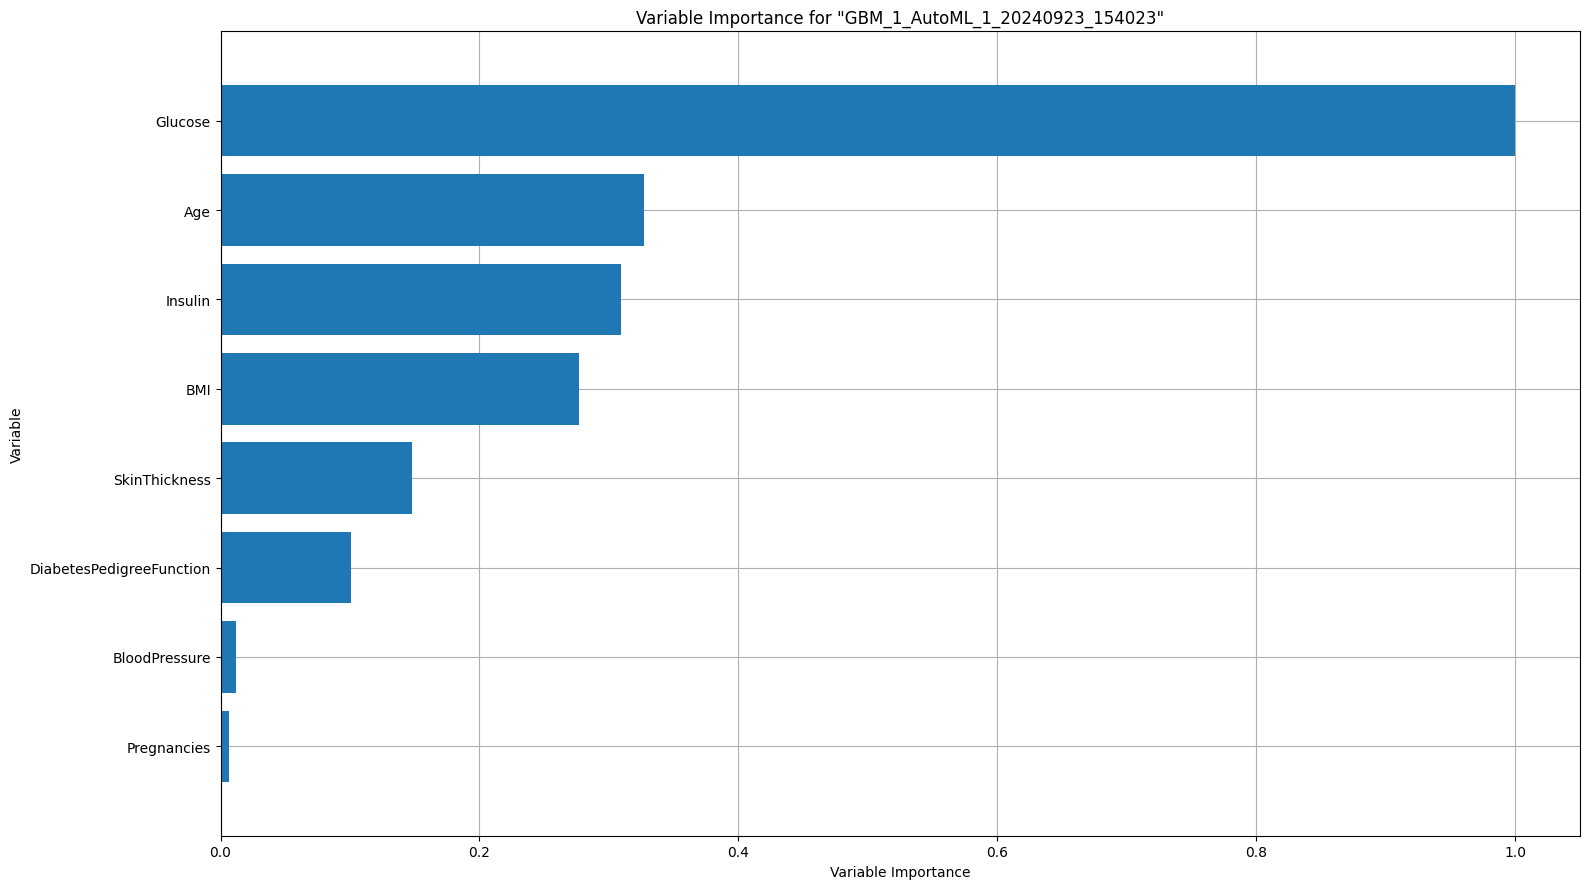

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

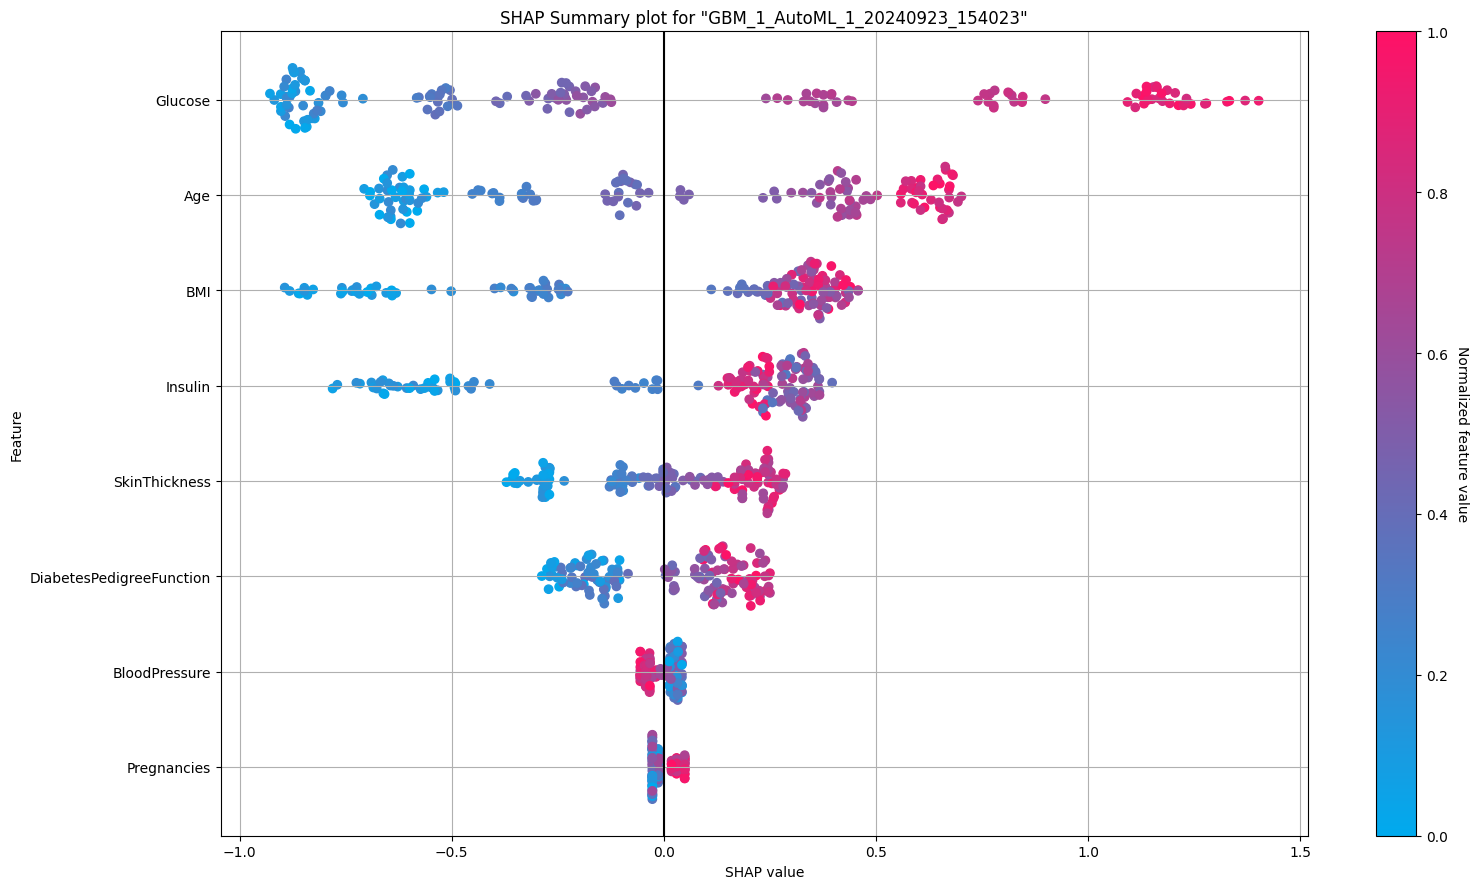

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

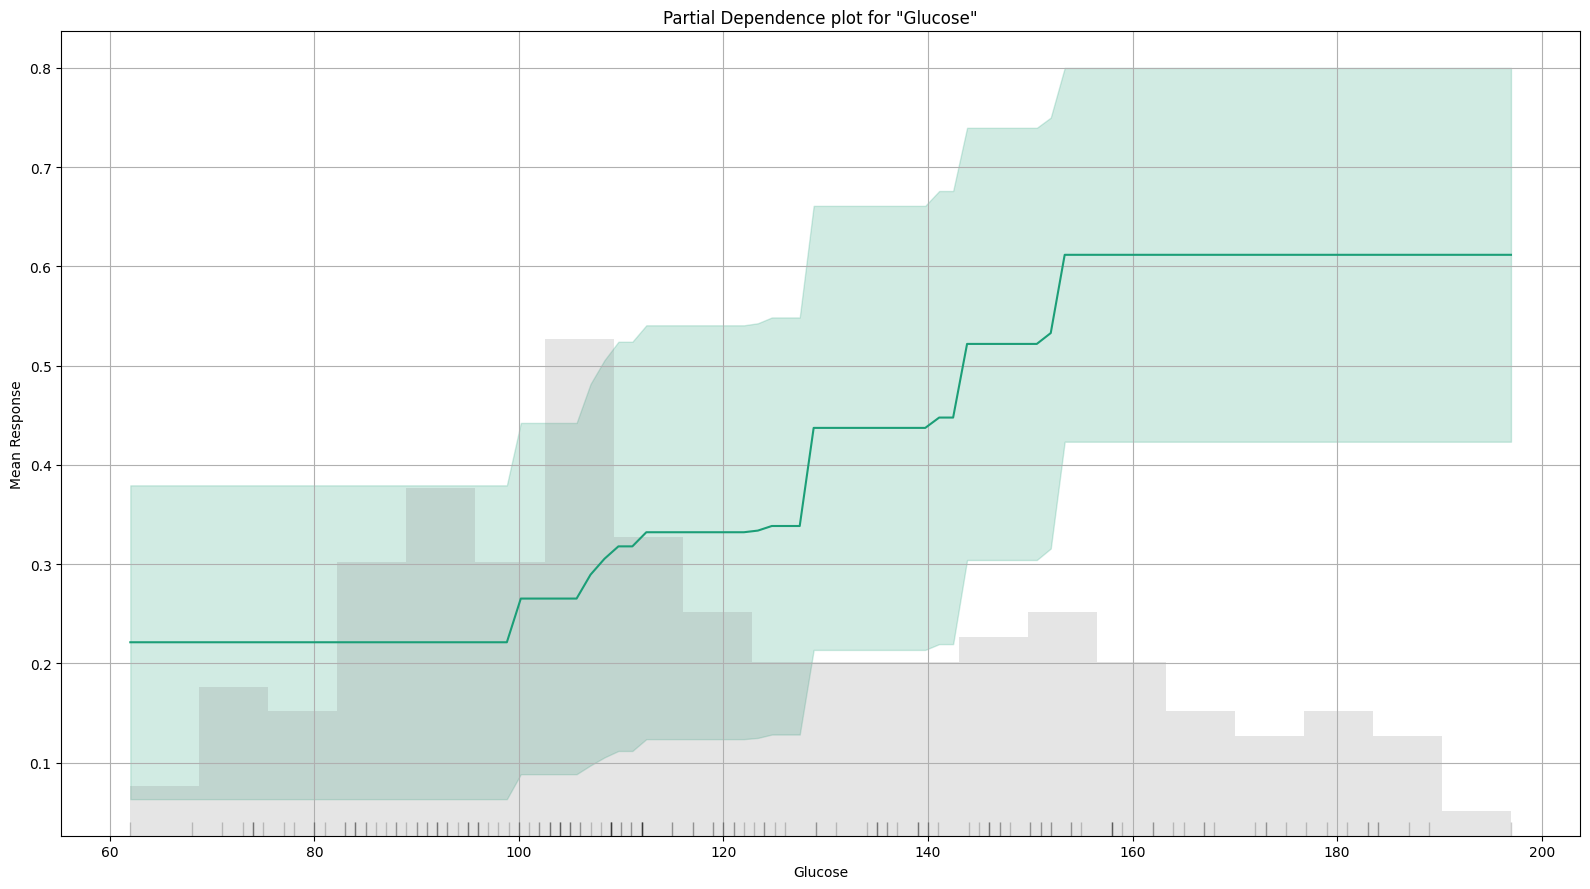

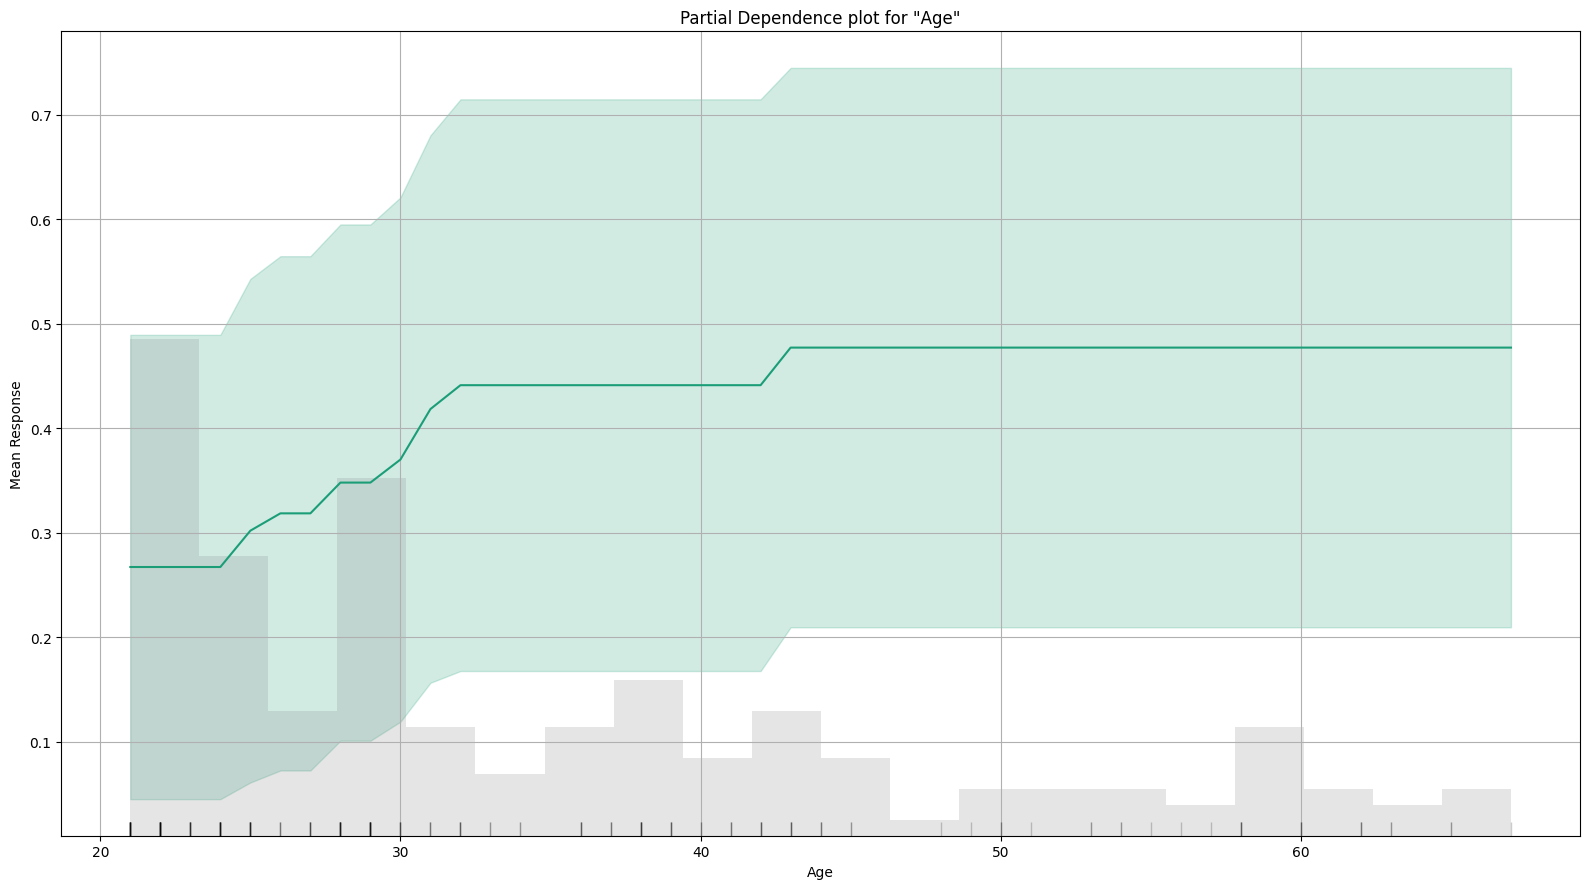

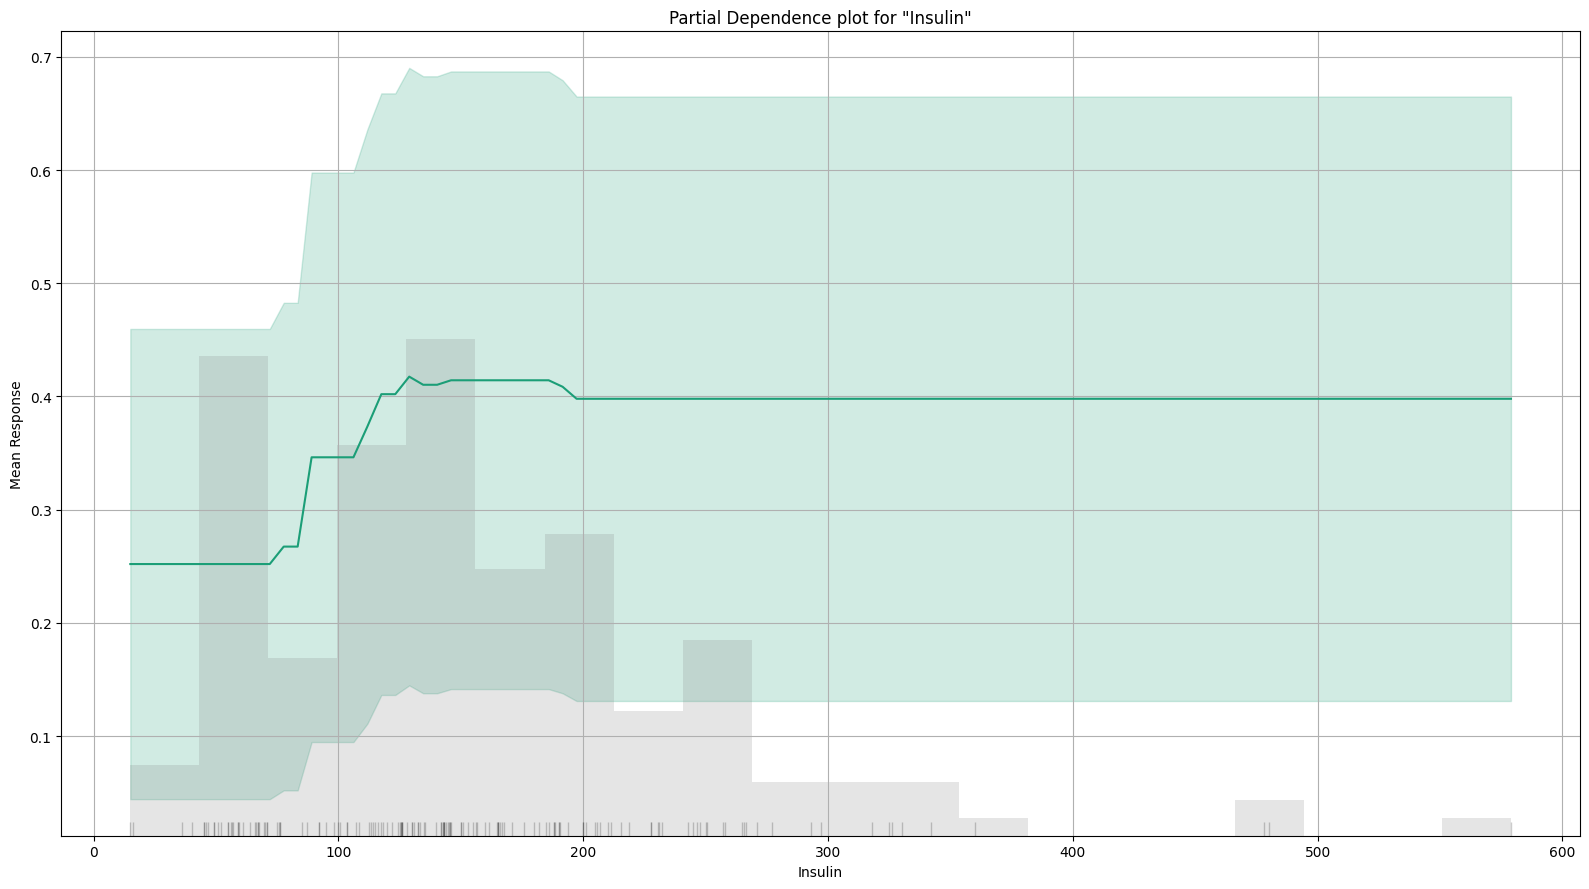

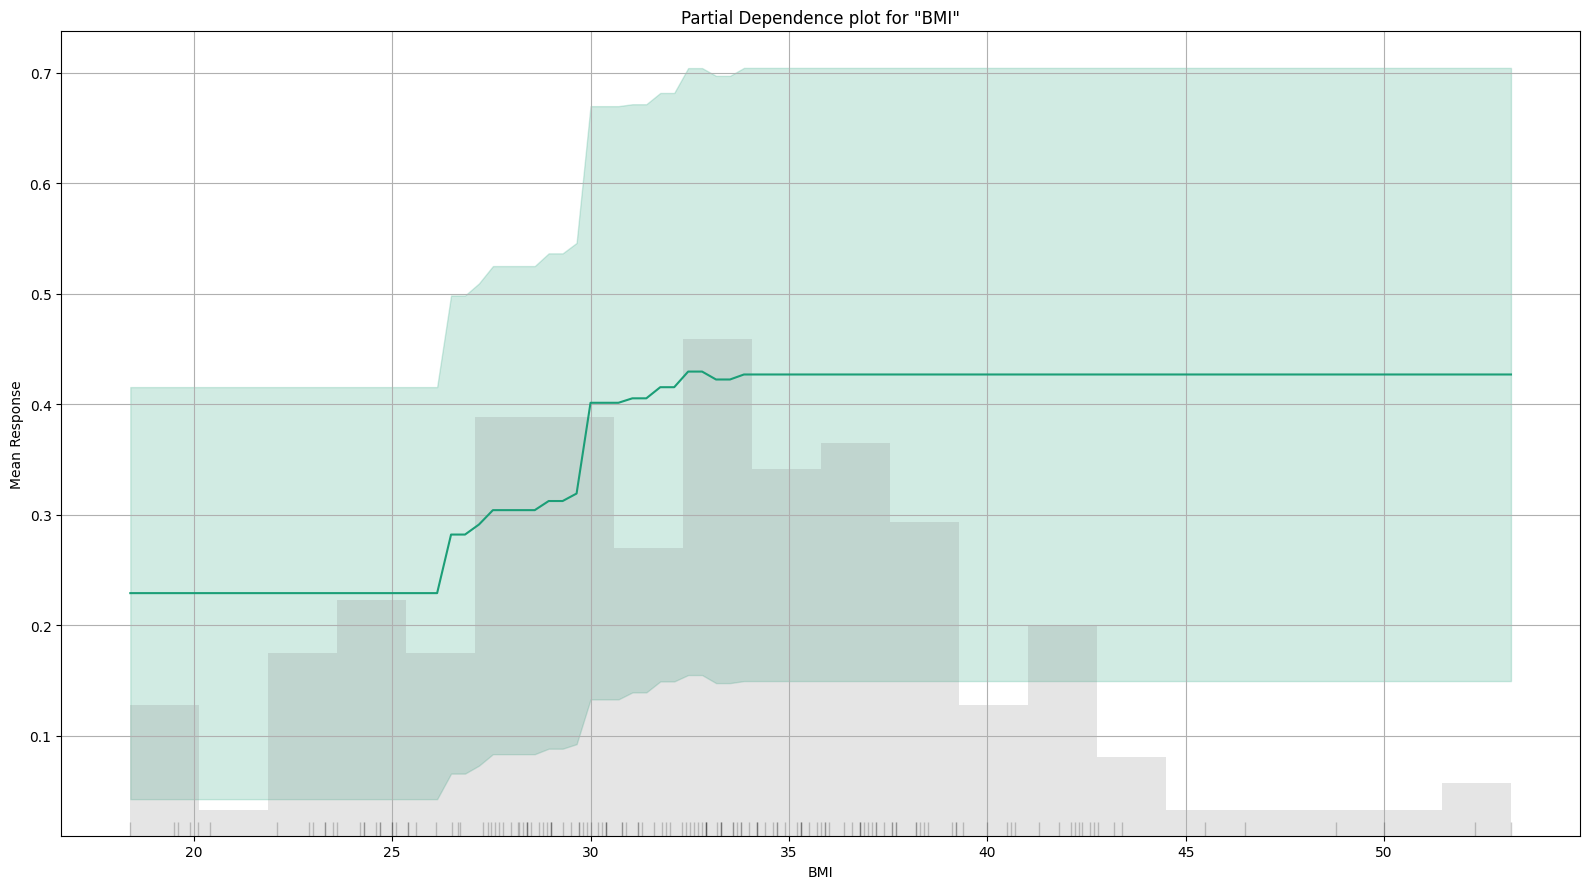

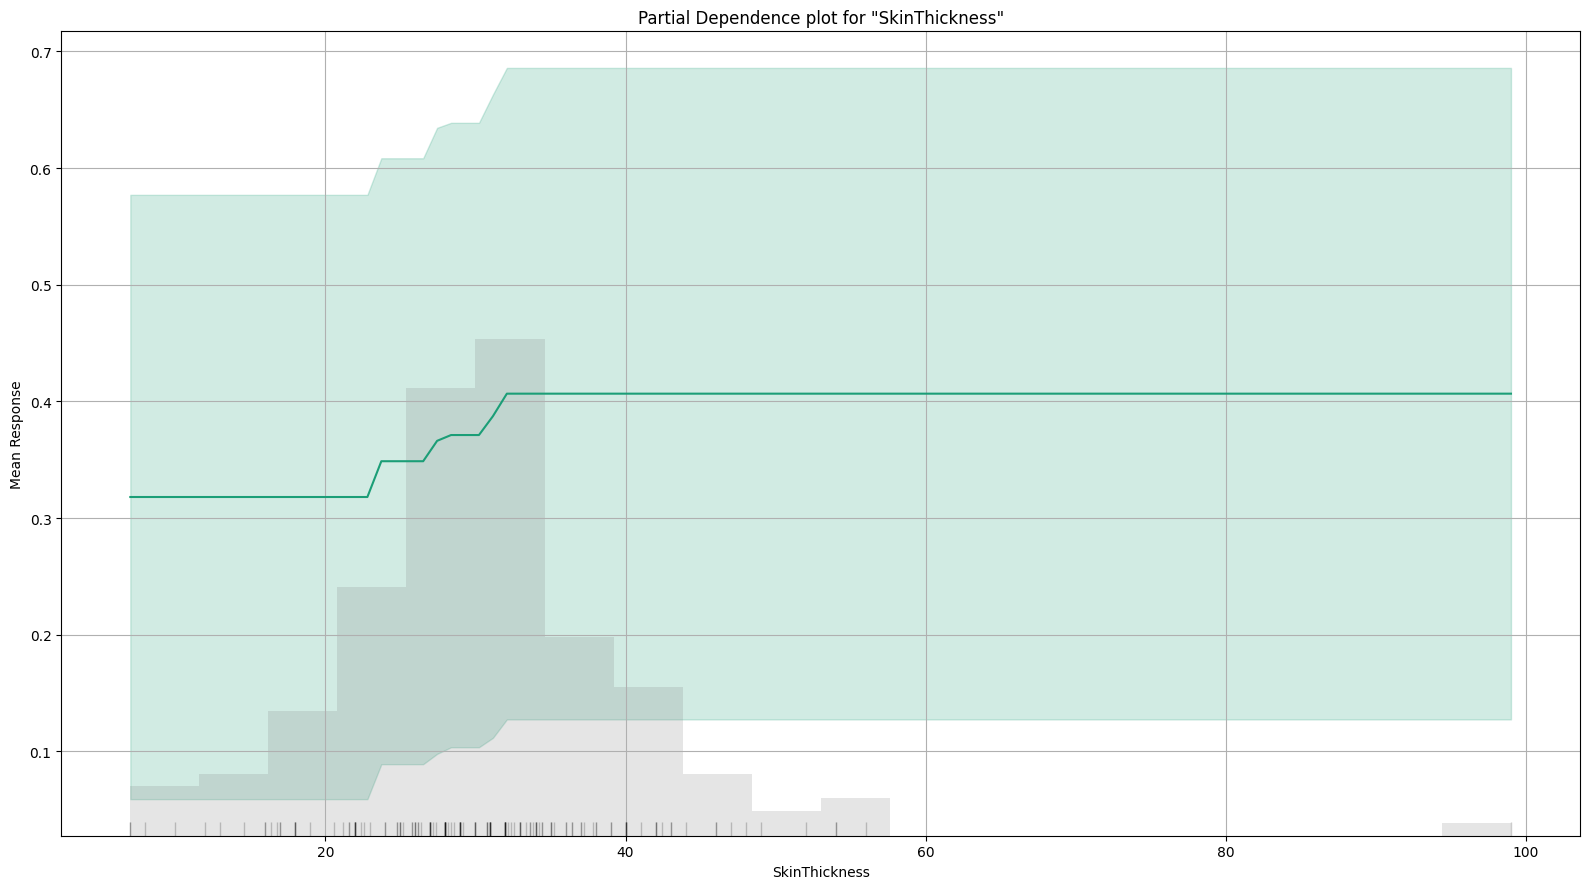

# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## GBM_1_AutoML_1_20240923_154023

,no,yes,Error,Rate
no,69.0,30.0,0.303,(30.0/99.0)
yes,11.0,44.0,0.2,(11.0/55.0)
Total,80.0,74.0,0.2662,(41.0/154.0)


# Learning Curve Plot

> Learning curve plot shows the loss function/metric dependent on number of iterations or trees for tree-based algorithms. This plot can be useful for determining whether the model overfits.

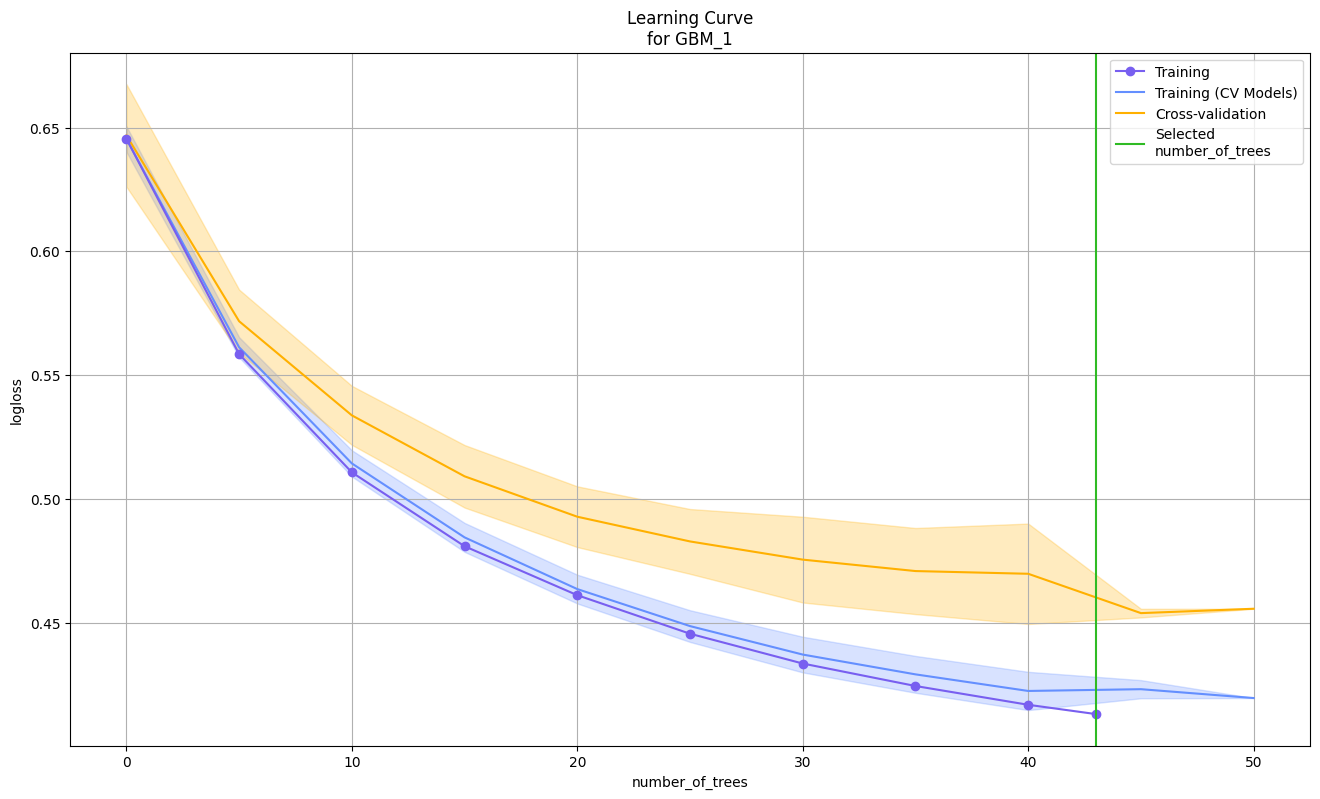

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

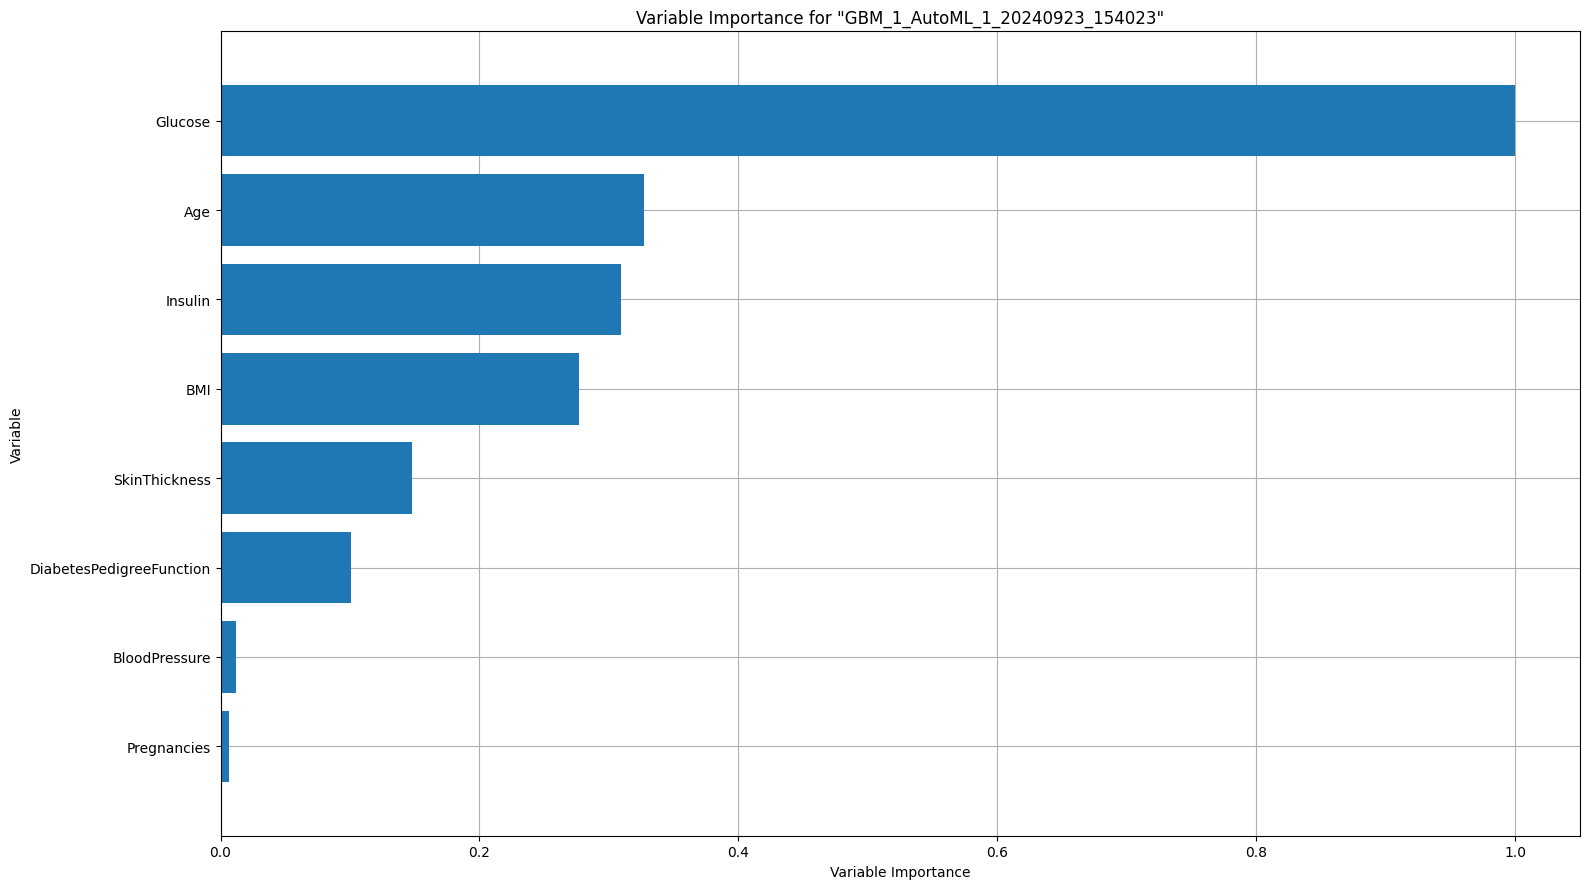

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

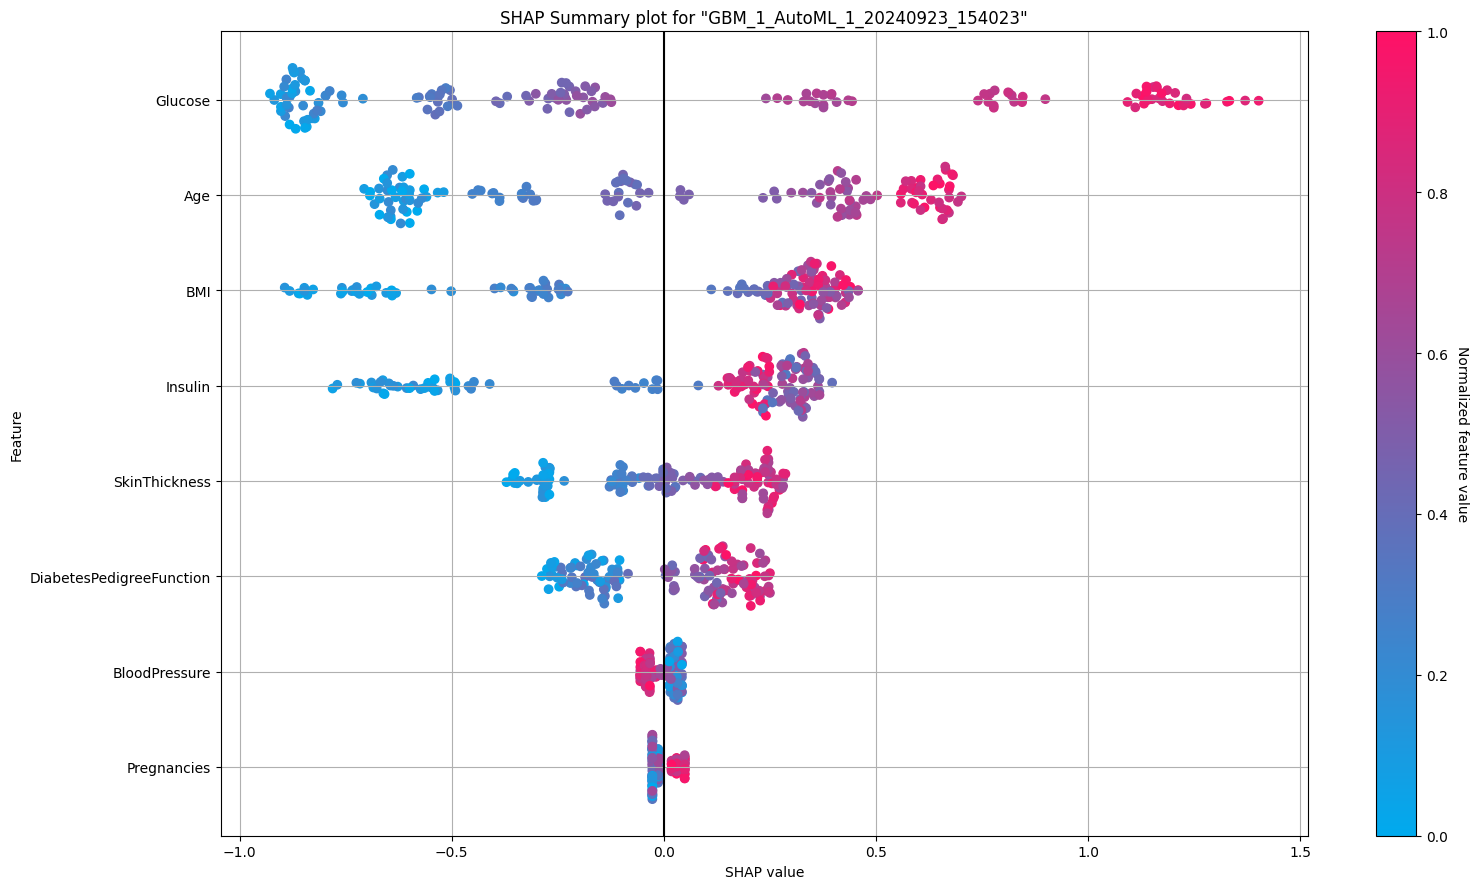

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

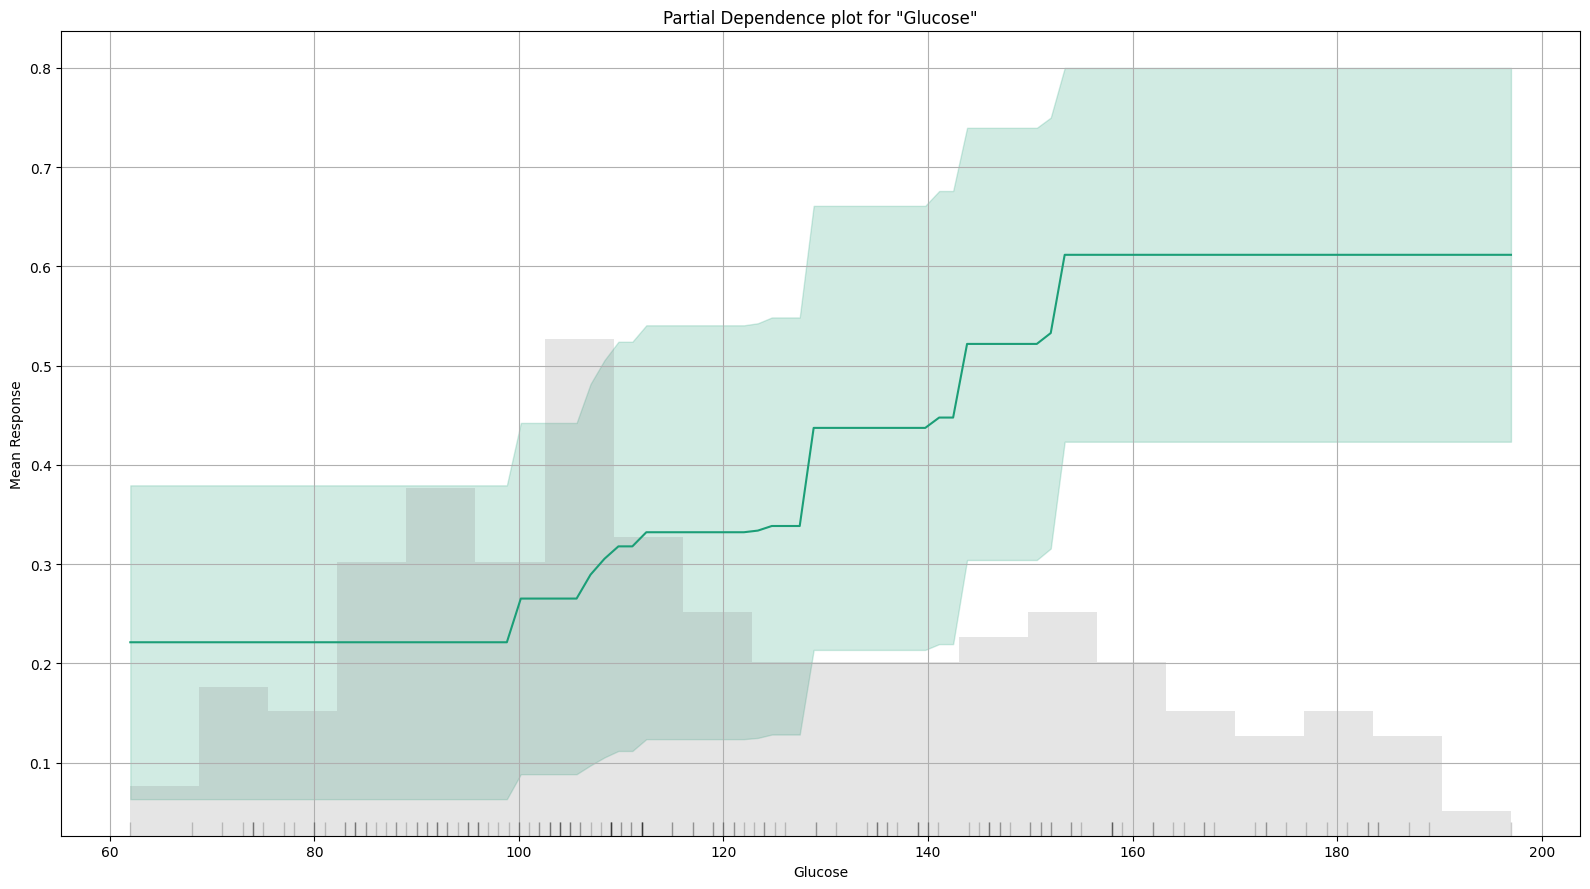

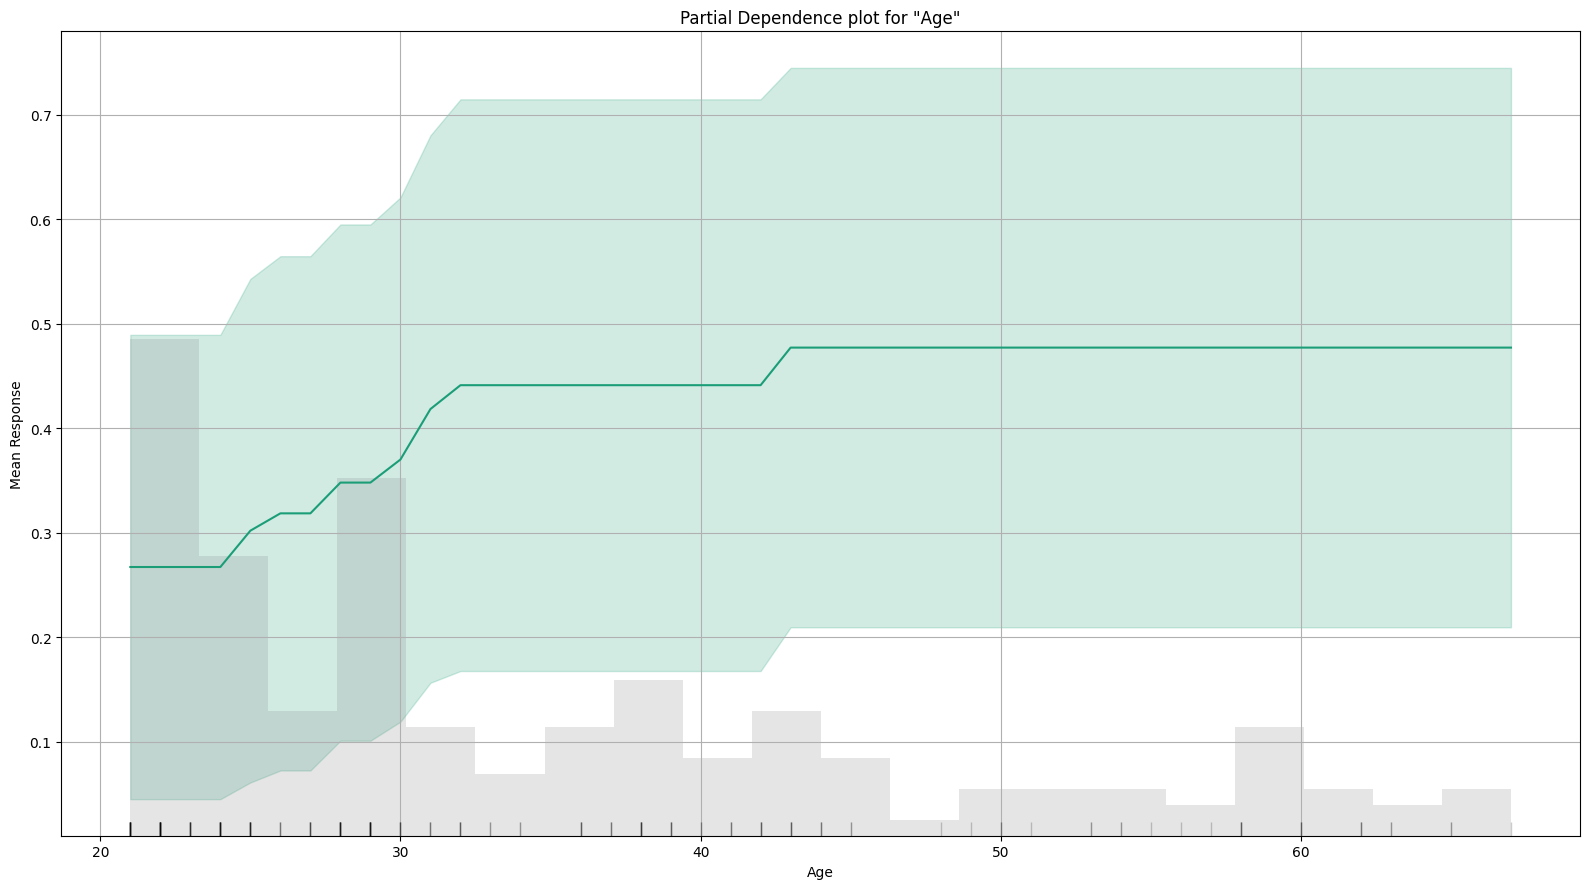

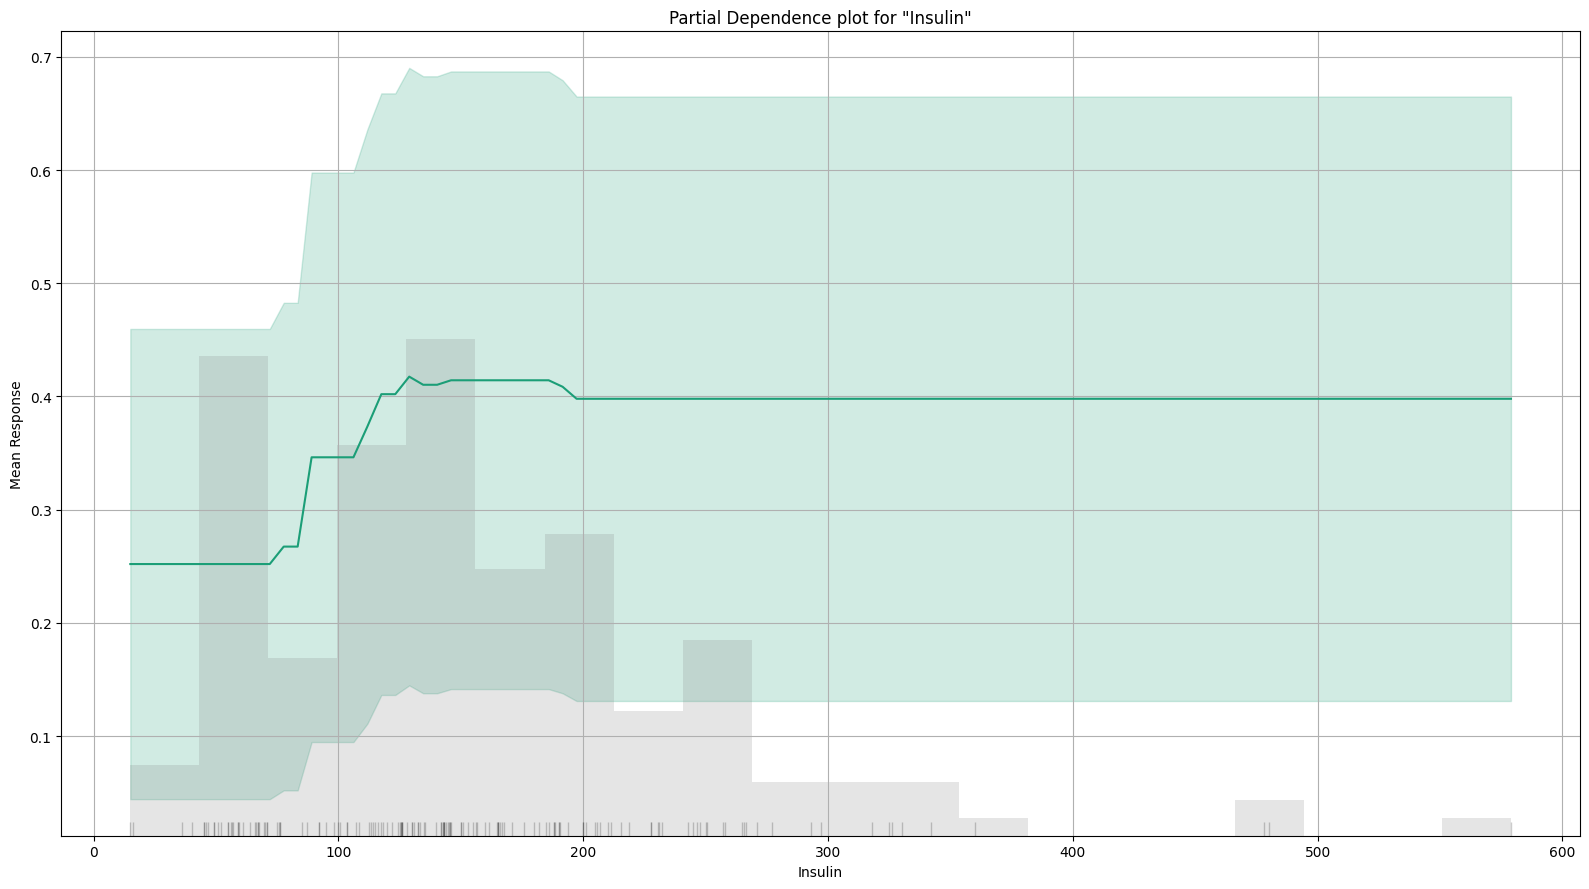

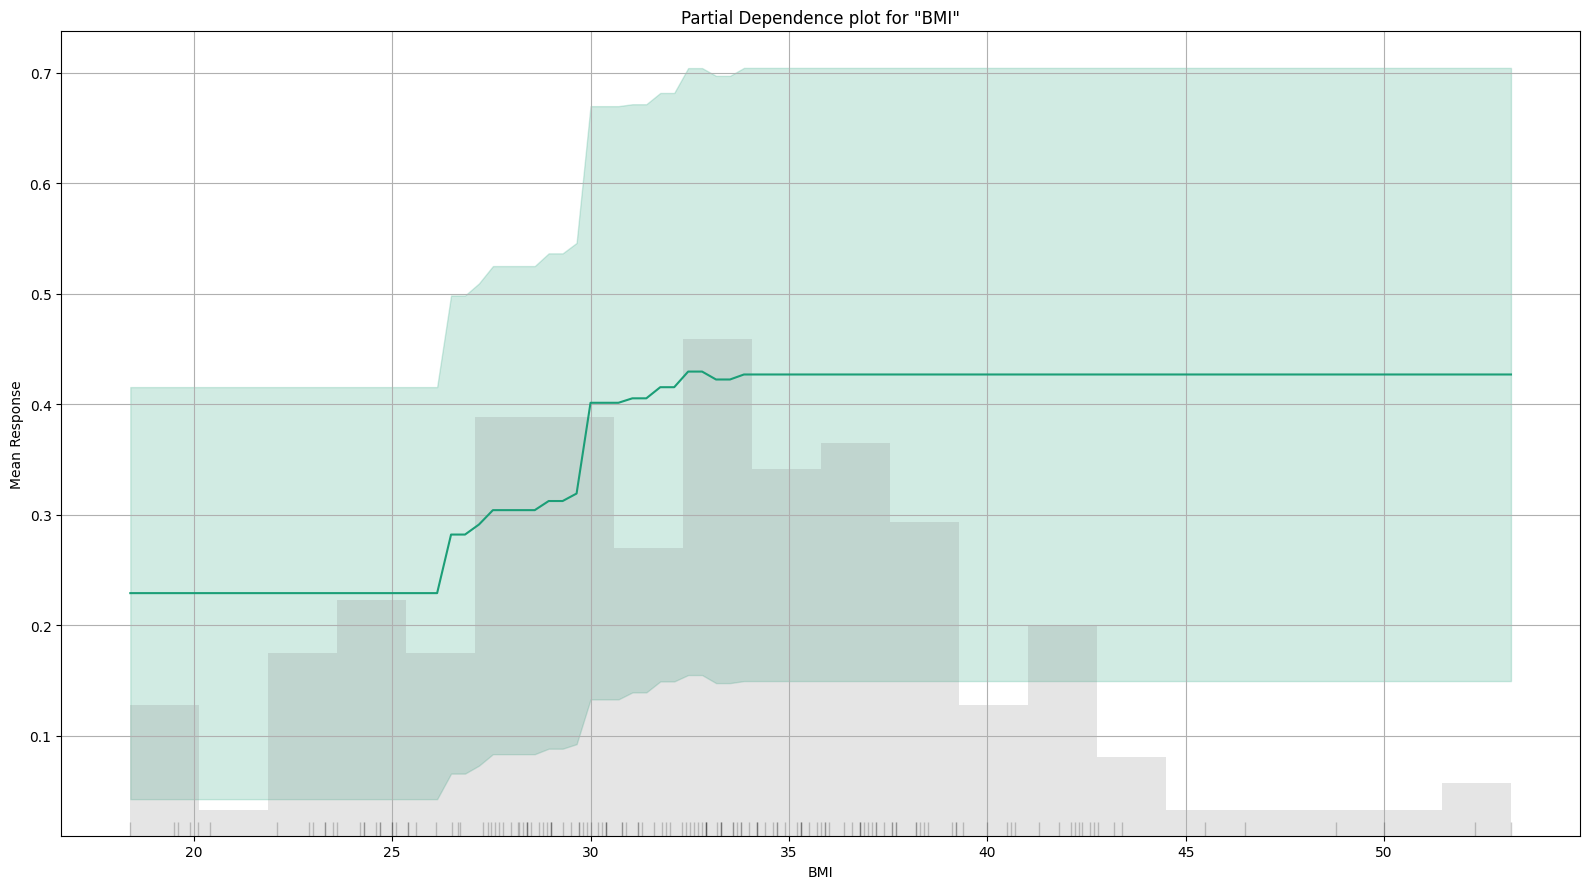

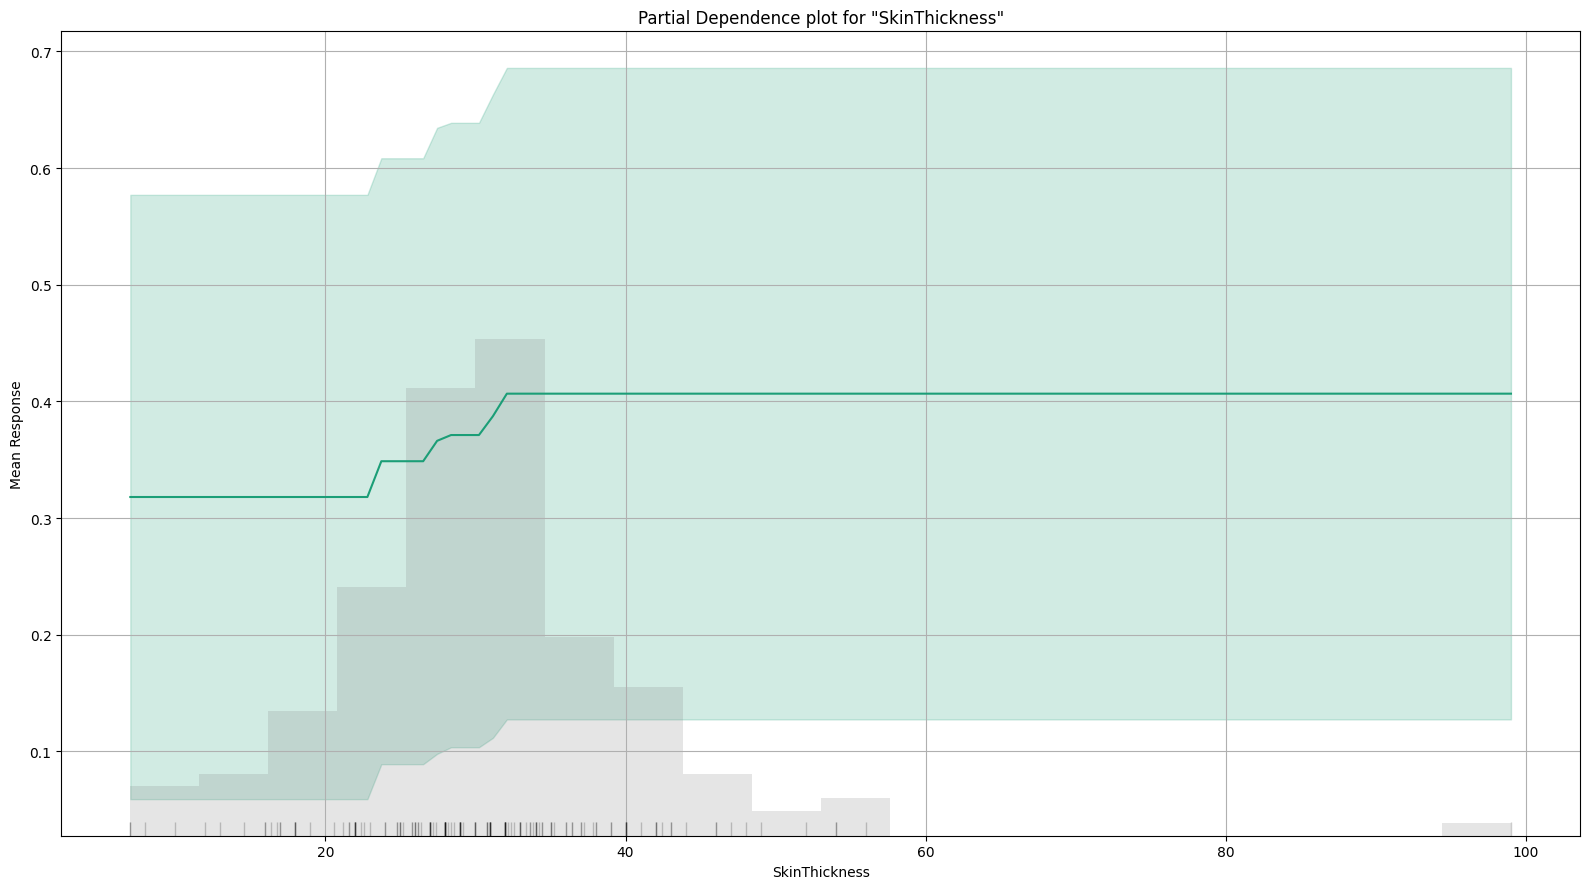

In [ ]:
best_model.explain(test)

In [ ]:
import pandas as pd

# Create a DataFrame to represent the feature importance data
data = {
    'variable': ['Glucose', 'Age', 'Insulin', 'BMI', 'SkinThickness', 'DiabetesPedigreeFunction', 'BloodPressure', 'Pregnancies'],
    'relative_importance': [136.458649, 44.601028, 42.162167, 37.809692, 20.162033, 13.784797, 1.623452, 0.851550],
    'scaled_importance': [1.000000, 0.326846, 0.308974, 0.277078, 0.147752, 0.101018, 0.011897, 0.006240],
    'percentage': [0.458756, 0.149943, 0.141744, 0.127111, 0.067782, 0.046343, 0.005458, 0.002863]
}

# Convert the data into a DataFrame
df = pd.DataFrame(data)

# Add Rank column (1 for the highest importance, and so on)
df['rank'] = df['relative_importance'].rank(ascending=False, method='min').astype(int)

# Add Cumulative Importance column
df = df.sort_values(by='relative_importance', ascending=False)
df['cumulative_importance'] = df['percentage'].cumsum()

# Add Importance Category column (High, Medium, Low)
def importance_category(percentage):
    if percentage >= 0.2:
        return 'High'
    elif percentage >= 0.05:
        return 'Medium'
    else:
        return 'Low'

df['importance_category'] = df['percentage'].apply(importance_category)

# Display the DataFrame with added analysis columns
df


,variable,relative_importance,scaled_importance,percentage,rank,cumulative_importance,importance_category
0,Glucose,136.458649,1.000000,0.458756,1,0.458756,High
1,Age,44.601028,0.326846,0.149943,2,0.608699,Medium
2,Insulin,42.162167,0.308974,0.141744,3,0.750443,Medium
3,BMI,37.809692,0.277078,0.127111,4,0.877554,Medium
4,SkinThickness,20.162033,0.147752,0.067782,5,0.945336,Medium
5,DiabetesPedigreeFunction,13.784797,0.101018,0.046343,6,0.991679,Low
6,BloodPressure,1.623452,0.011897,0.005458,7,0.997137,Low
7,Pregnancies,0.851550,0.006240,0.002863,8,1.000000,Low


In [ ]:
single_instance = {
    'Pregnancies': 2,
    'Glucose': 140,
    'BloodPressure': 80,
    'SkinThickness': 35,
    'Insulin': 120,
    'BMI': 30.0,
    'DiabetesPedigreeFunction': 0.5,
    'Age': 45
}

# Convert the single instance into a pandas DataFrame
import pandas as pd
single_df = pd.DataFrame([single_instance])

# Convert the pandas DataFrame into an H2OFrame
single_h2o_frame = h2o.H2OFrame(single_df)

prediction = best_model.predict(single_h2o_frame)

# Show the prediction result
print(prediction)


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
predict          no       yes
yes        0.279417  0.720583
[1 row x 3 columns]

